In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE,CAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib
import time
import ae_train
from losses import *
from telescope_torch import *
import CAE_generate_stats

/uscms_data/d3/nswood/Notebooks/AE_Dev/CAE_generate_stats.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_data.append(torch.tensor(data[-dt_size:]))
/uscms_data/d3/nswood/Notebooks/AE_Dev/CAE_generate_stats.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_pred.append(torch.tensor(pred[-dt_size:]))


MSE 1.0656110048294067
Median 0.24823708832263947
Standard Devitaion 3.2081122398376465
Average std error 2.1774065494537354
Average % Error of Energy Reconstruction nan


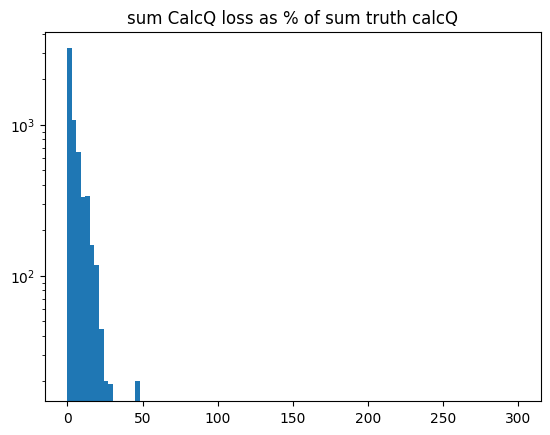

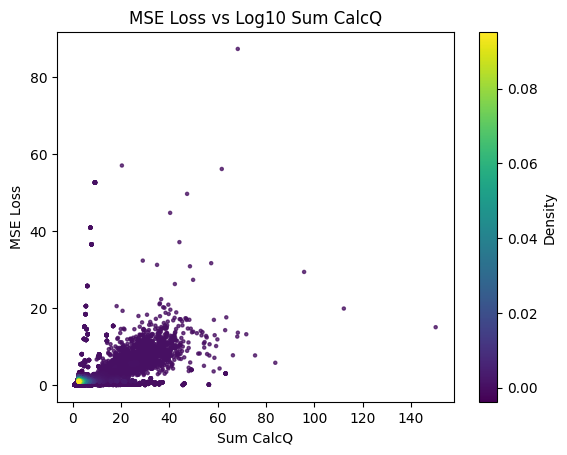

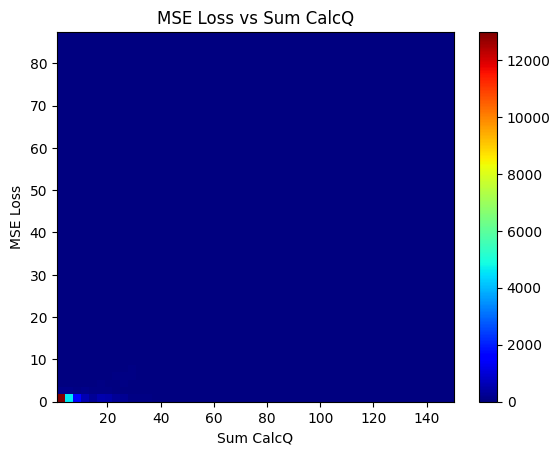

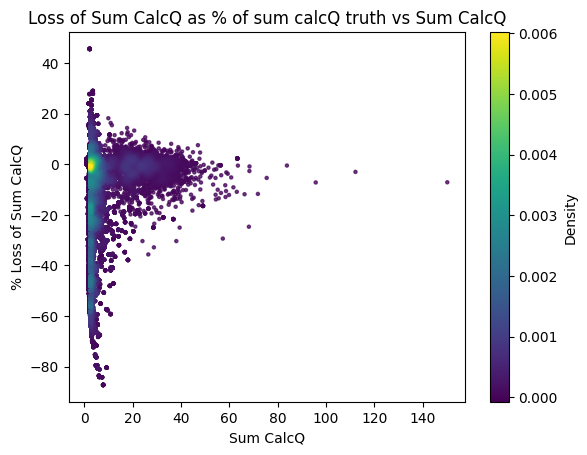

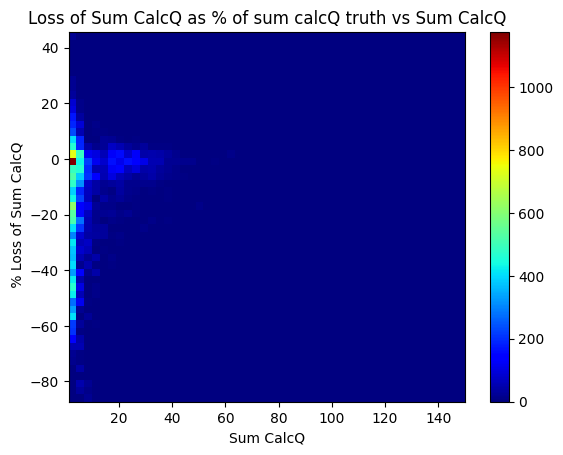

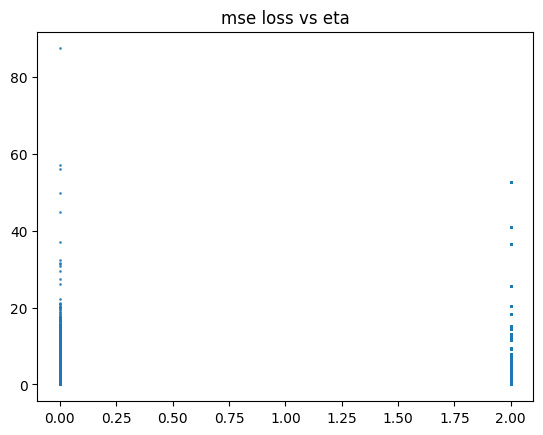

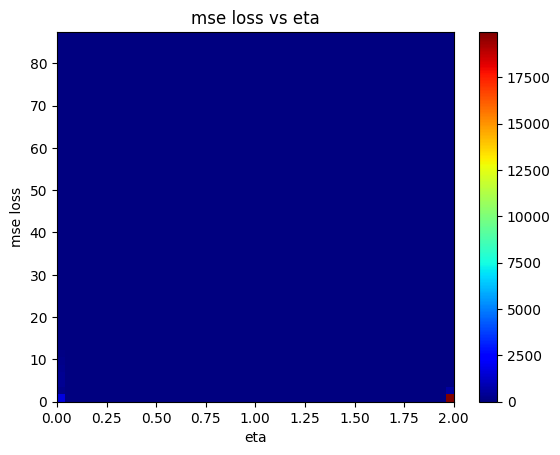

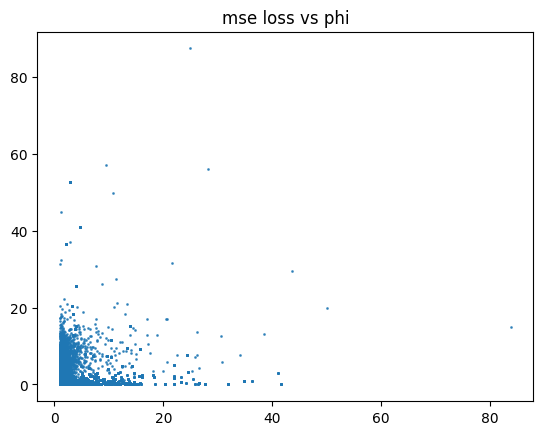

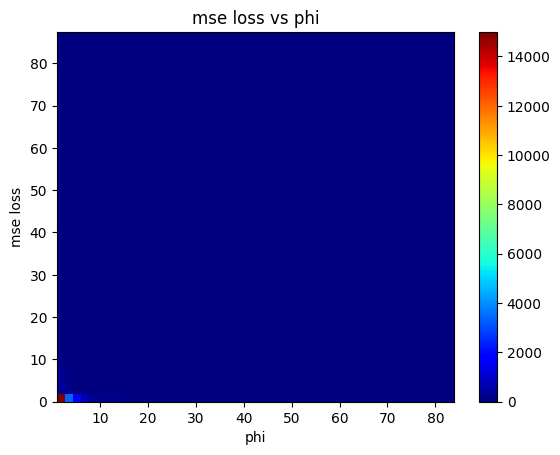

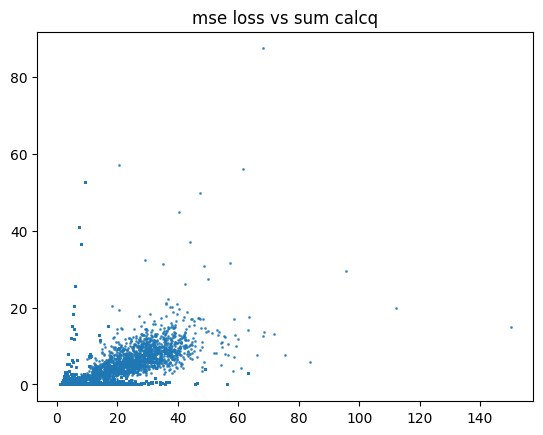

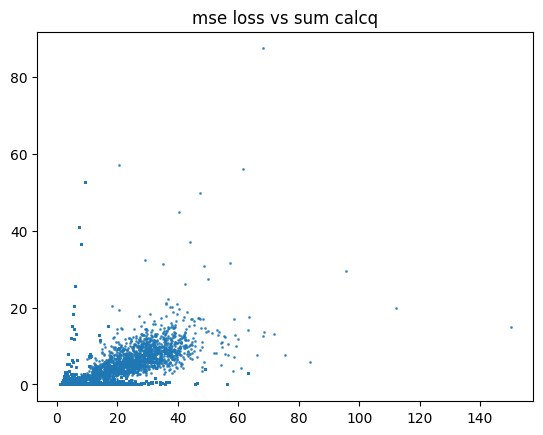

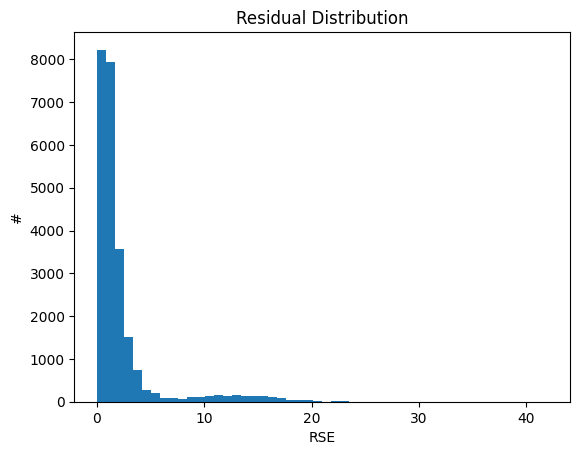

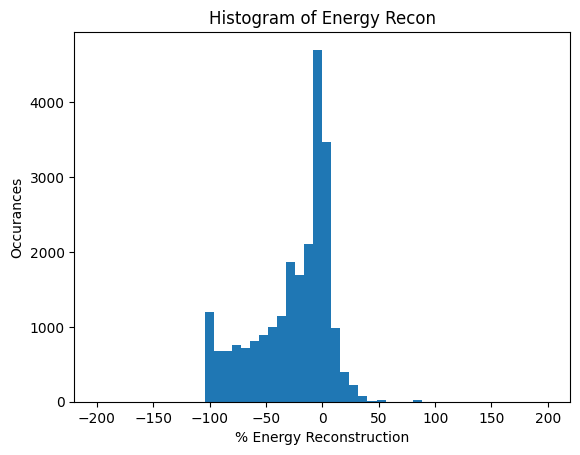

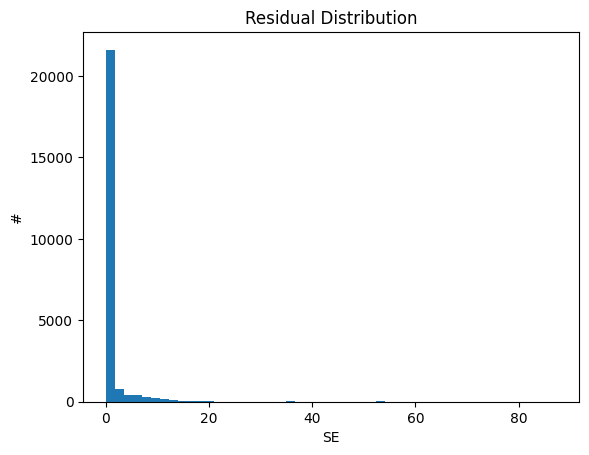

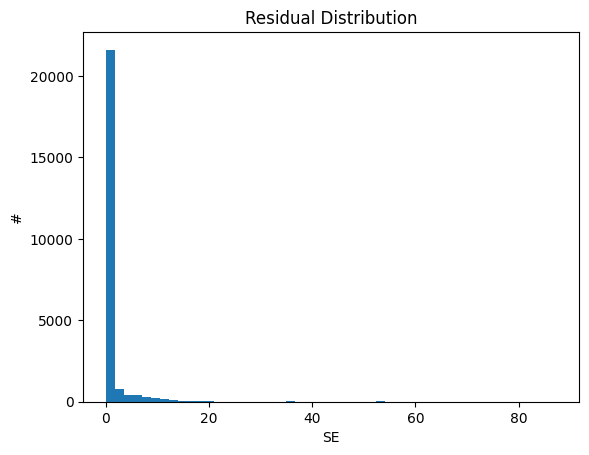

In [160]:

data_path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/MIT_TTbar'

importlib.reload(CAE_generate_stats)

CAE_generate_stats.gen_batch_stats("models/batched_models/test_CAE",
                                  data_path
                                  )

In [145]:

path = 'MIT_TTbar'
prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

data = []
for p in prefixed:
    data.append([torch.load(f'{path}/{p}'),p])

In [146]:
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

models = os.listdir(path)[9:]

In [148]:

#all past 29
cur_train = []
for m in models:
    if int(m[8]) == 2:
        cur_train.append(m)

In [149]:
#Calculating MSE of trained models
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

cur_model = models[1]

def get_data(data,cur_model):
    cur_data = []
    for d in data:
        if d[1] == cur_model:
            cur_data = d[0]
            break
    return cur_data

test_set = []
train_set = []
pred_set = []

for m in cur_train:
    cur_model = torch.load(os.path.join(path,m)).to('cpu')
    cur_data = get_data(data,m).to('cpu')
    if len(cur_data)< 20000:
        train_set.append(cur_data[0:int(0.8*len(cur_data))])
        test_data = cur_data[-int(0.19*len(cur_data)):]
        test_set.append(test_data)
    else:
        train_set.append(cur_data[0:int(0.8*20000)])

        test_data = cur_data[-int(0.19*20000):]
        test_set.append(test_data)
    
    
    
    

In [150]:
device = 'cuda'
train_dt = torch.vstack(train_set).to(device)
test_dt = torch.vstack(test_set).to(device)

In [128]:
def loss_p(data,pred,epoch,mean,std,alpha = 0.2,cut = 100):
    s = torch.sum(data[:,0:48],dim=1)
    s[s ==0.0000] = 1
    return new_loss(data,pred,epoch,mean,std) + 0.25*np.abs(torch.mean(torch.sum(pred-data[:,0:48],dim=1)/s).item()*100)

In [151]:
mean = 0
std = 1

In [152]:
size_1_train =len(train_dt)
size_1_test = len(test_dt)
train_loc = train_dt
test_loc = test_dt
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train_1 = train_dt[:,0:48]
test_1 = test_dt[:,0:48]


train_tc_sum = torch.unsqueeze(torch.sum(train_1[:,0:48],dim = 1),dim=1)
test_tc_sum = torch.unsqueeze(torch.sum(test_1[:,0:48],dim = 1),dim=1)

# train = torch.vstack([train,largest[0:1000]] )
train_1=train_1[torch.randperm(train_1.size()[0])]
test_1=test_1[torch.randperm(test_1.size()[0])]
train_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_1),train_tc_sum),
    batch_size=100,
    shuffle=False
)

test_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_1),test_tc_sum),
    batch_size=100,
    shuffle=False
)

In [131]:
def combo_loss(data,pred,epoch,mean,std,alpha = 0.2,cut = 50):
    error = dif_weighted_AE_MSE(data,pred,alpha = alpha)
    tele_loss = torch.mean(telescopeMSE2(data[:,0:48], pred))
    if epoch < cut:
        return error + tele_loss
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.mean(torch.norm(sum_dt-sum_pred))
        
    
        return  error + tele_loss + 0.01*sum_error*np.min([(epoch-cut)/cut,1])

In [153]:
!pwd

/uscms_data/d3/nswood/Notebooks/AE_Dev


In [154]:
loss = new_loss

In [157]:
## fine-tune autoencoder
#batch 500

# model_1 = torch.load('models/dt_3_greater_0_450_250_100_dif_2').to(device)
# model_1.decoders.add_module('ReLU',nn.ReLU())
                        
model_1 = CAE([48,450,16]).to(device)

# model_1 = torch.load('models/CAE_Models/dt_2_250_150').to(device)

test = test_dt
sum_TC_test = torch.unsqueeze(torch.sum(test_dt[:,0:48],dim=1),dim=1)
lr = 1.5e-4
num_epochs = 10

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)


data_test = test
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, (data,sum_TC) in enumerate(train_1_d1_flat):
        model_1.train()
        
        v_pred = model_1(data[:,0:48],sum_TC)
        
        batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
        
       
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_1_test = test[:,0:48]
    model_1.eval()
    
    test_pred = model_1(data_1_test,sum_TC_test)
    batch_1_test = loss(data_1_test[:,0:48], test_pred,epoch,mean,std)
    running_loss = np.mean(losses)
    running_1est_loss = batch_1_test.item()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
model_1.eval()
# torch.save(model_1,'models/CAE_Models/dt_2_450')

# AE_Stats.gen_all_stats(model_1(dt_1[-size_1_test:,0:48]).cpu(),dt_1[-size_1_test:,0:48].cpu(),dt_1[-size_1_test:].cpu())

Epoch 0, lr 0.0015
Epoch 0: Train 47.18565800969269, Test 41.31711959838867
Epoch 1, lr 0.0015
Epoch 1: Train 38.80514362599086, Test 24.885845184326172
Epoch 2, lr 0.0015
Epoch 2: Train 25.829493934925576, Test 17.72698974609375
Epoch 3, lr 0.0015
Epoch 3: Train 23.493343430172406, Test 19.01145362854004
Epoch 4, lr 0.0015
Epoch 4: Train 40.5022831894819, Test 37.62091064453125
Epoch 5, lr 0.0015
Epoch 5: Train 26.22097753803321, Test 18.74861717224121
Epoch 6, lr 0.0015
Epoch 6: Train 20.451870139362743, Test 16.446983337402344
Epoch 7, lr 0.0015
Epoch 7: Train 16.786091466937638, Test 10.94554615020752
Epoch 8, lr 0.0015
Epoch 8: Train 20.52500497317494, Test 14.333253860473633
Epoch 9, lr 0.0015
Epoch 9: Train 19.22767969798759, Test 14.009754180908203


CAE(
  (encoders): ModuleList(
    (0): Linear(in_features=48, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoders): ModuleList(
    (0): ReLU()
    (1): Linear(in_features=17, out_features=150, bias=True)
    (2): ReLU()
    (3): Linear(in_features=150, out_features=250, bias=True)
    (4): ReLU()
    (5): Linear(in_features=250, out_features=48, bias=True)
    (6): ReLU()
  )
)

MSE 3.5684316158294678
Median 0.744543731212616
Standard Devitaion 23.325477600097656
Average std error 4.052463531494141
Average % Error of Energy Reconstruction inf


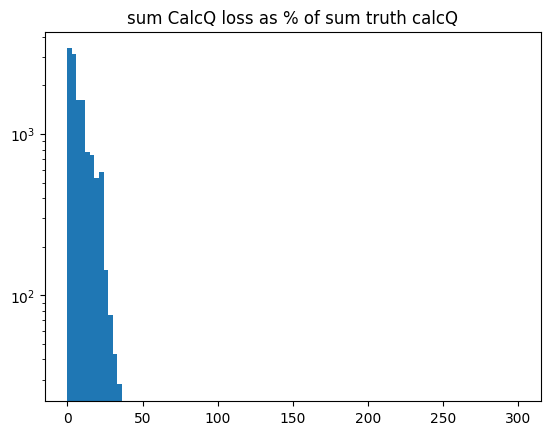

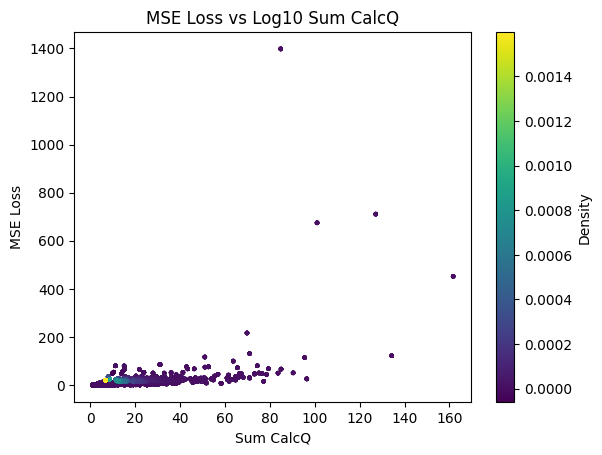

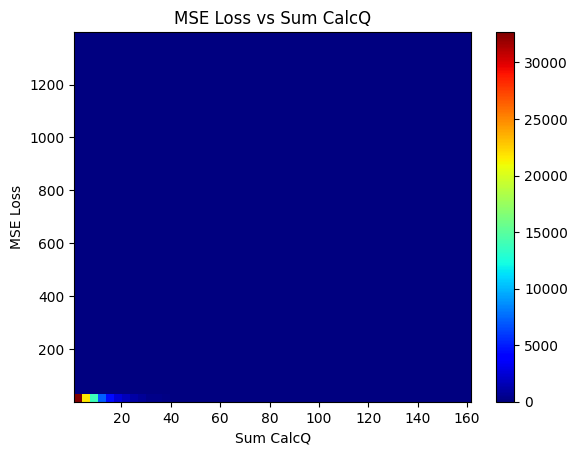

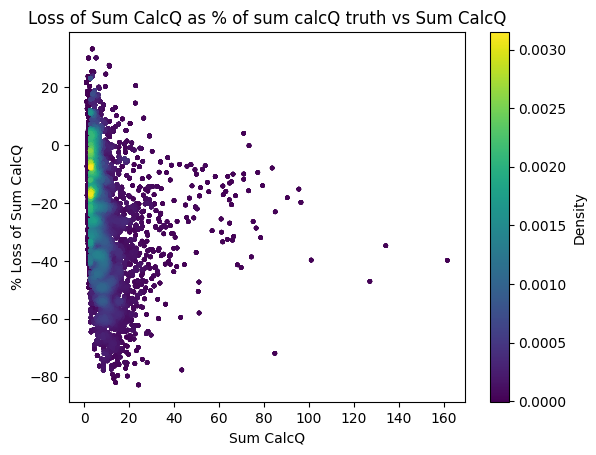

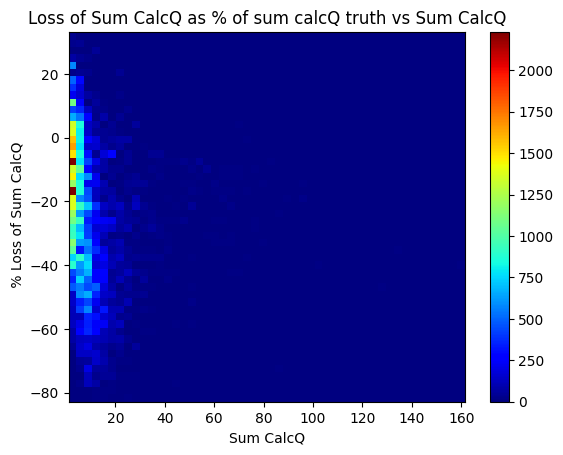

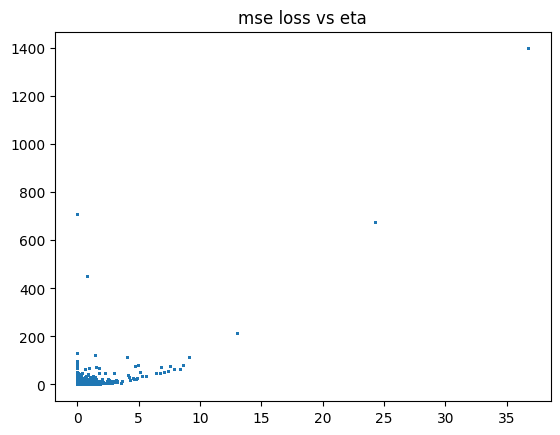

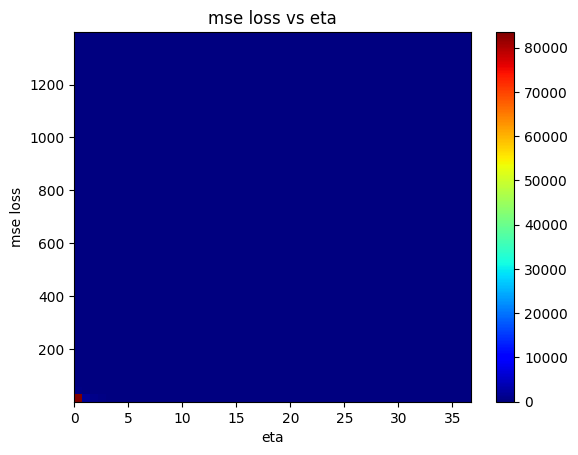

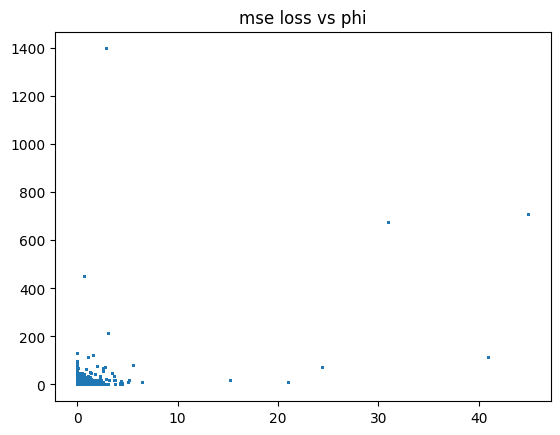

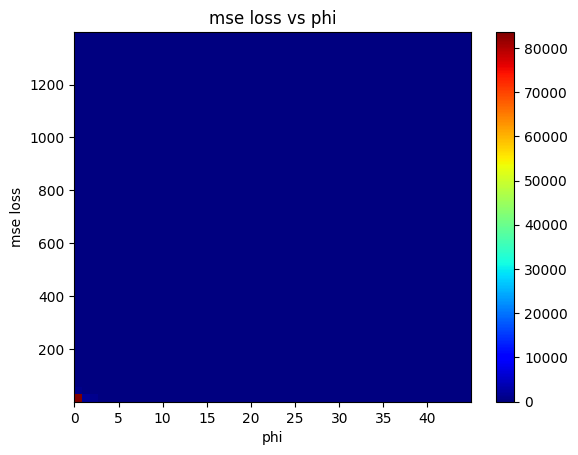

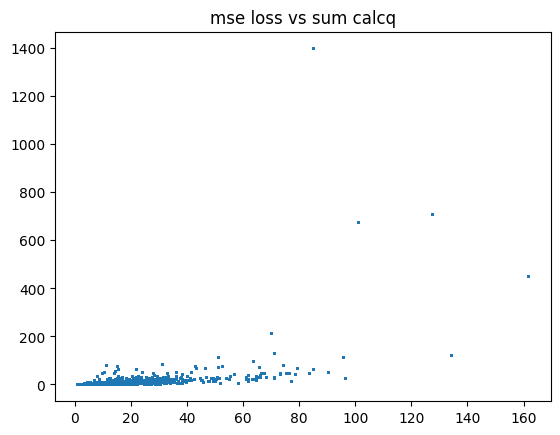

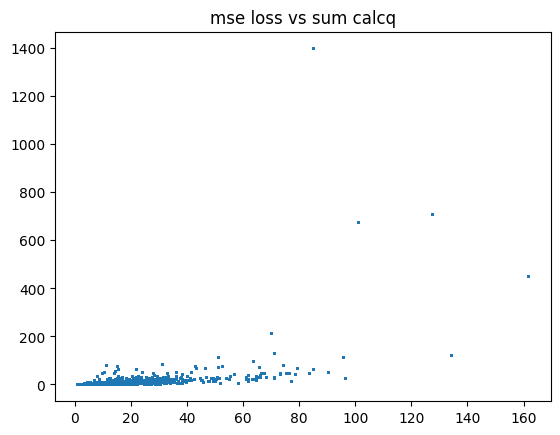

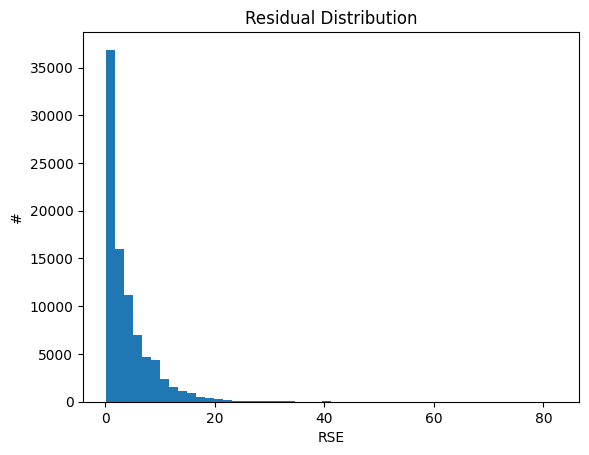

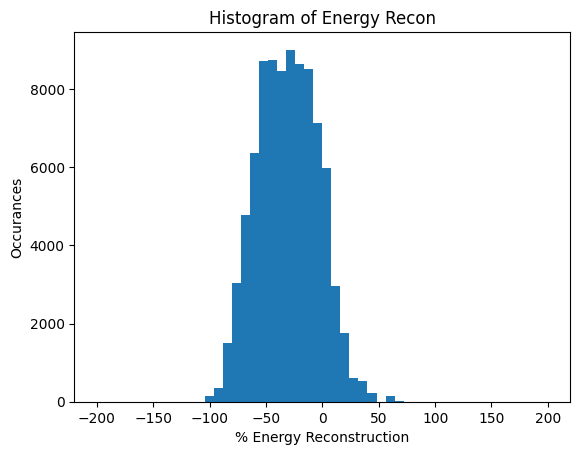

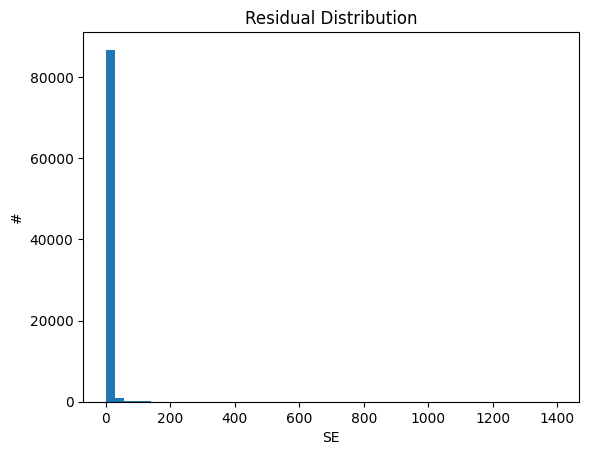

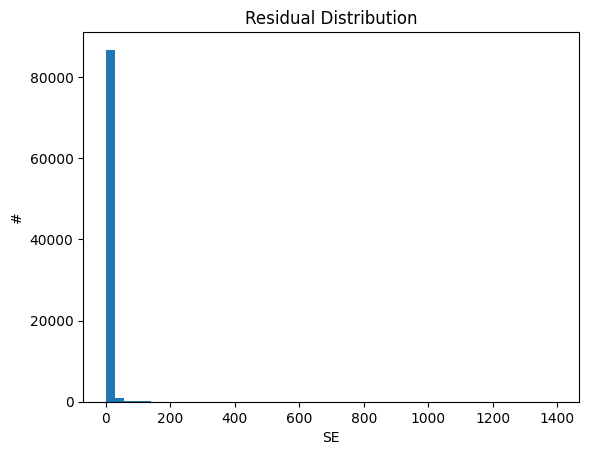

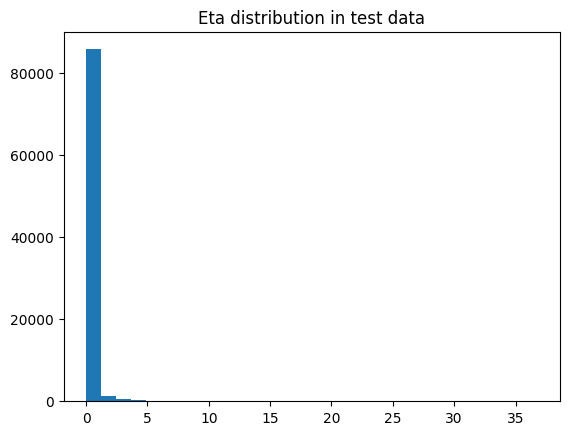

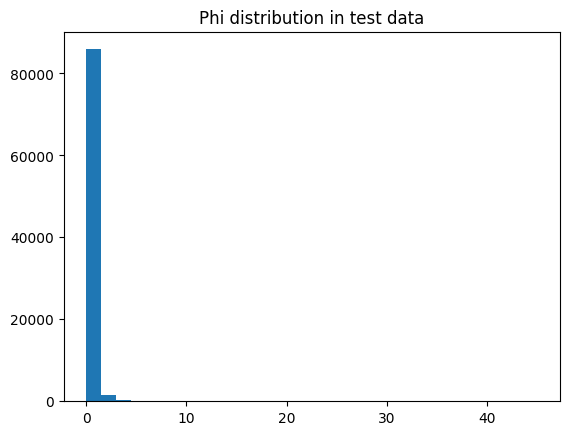

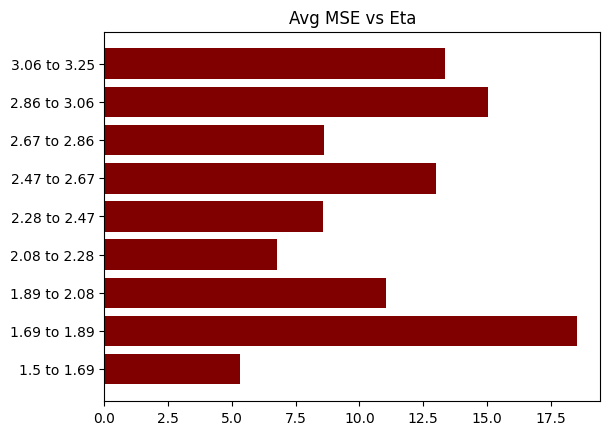

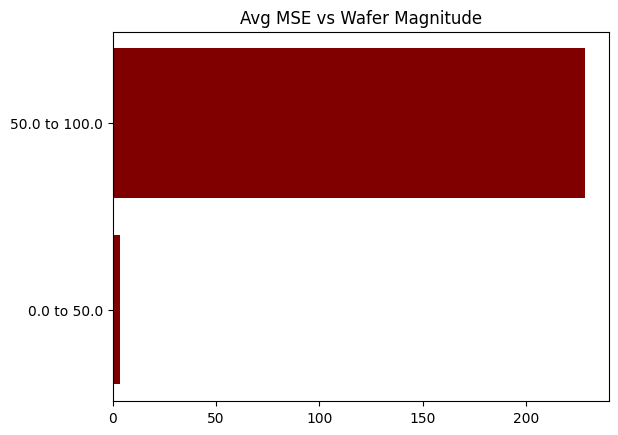

tensor([[0.0000e+00, 1.6814e+00, 1.5713e+01, 5.7769e+00, 9.1572e+00],
        [2.0356e+00, 1.9284e+00, 2.5772e+01, 1.7717e+01, 1.6334e+01],
        [0.0000e+00, 0.0000e+00, 1.3177e+01, 5.0492e+00, 9.3122e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 2.0568e+00, 1.9052e-01, 1.1718e+00],
        [0.0000e+00, 2.5023e-02, 1.4966e+00, 3.1451e-03, 1.1844e-01],
        [0.0000e+00, 0.0000e+00, 1.9234e+00, 1.5636e-02, 2.7652e-01]],
       grad_fn=<CatBackward0>)

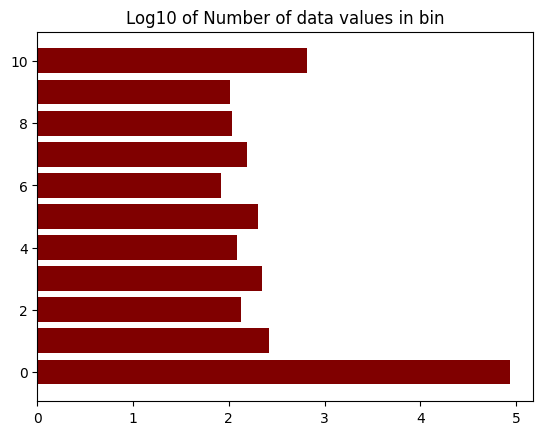

In [158]:
AE_Stats.gen_all_stats(test_pred.cpu(),data_1_test.cpu(),data_1_test.cpu())


In [2]:
import CondAE

In [3]:
# provide path to data
data_path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/MIT_TTbar'

In [4]:
all_files = os.listdir(data_path)
dt_files = []
for f in all_files:
    if f[0:7] == 'dt_norm' and (f[-3:] != 'low' and f[-4:] !='high'):
        dt_files.append(f)
      

In [5]:
all_files = os.listdir(data_path)
dt_files = []
for f in all_files:
    if f[0:7] == 'dt_norm' and (f[-3:] != 'low' and f[-4:] !='high'):
        dt_files.append(f)

In [9]:
importlib.reload(CondAE)

<module 'CondAE' from '/uscms_data/d3/nswood/Notebooks/AE_Dev/CondAE.py'>

In [27]:
CondAE.train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = False,
              loss = combo_loss, 
              path_1 = 'models/dt_1_combo_loss',
              path_2 = 'models/dt_2_combo_loss',
              path_3 = 'models/dt_3_combo_loss',
             dir_label ='conda_450_150_combo_loss',
             epochs= 50,
             tele = False,
             batch = 200, 
             lr = 8.5e-7)

dt_norm_2_9
TRAINING MODEL dt_norm_2_9: 1/1
LOW
TRAINING INFO:
Total Dataset Size: 78165
Epoch 0, lr 8.5e-07
Epoch 0: Train 2.771, Test 2.739
MSE NON-NORMALIZED: Train MSE 26.897, Test MSE 29.900
Epoch 25, lr 8.5e-07
Epoch 25: Train 2.321, Test 2.312
MSE NON-NORMALIZED: Train MSE 22.595, Test MSE 25.207
HIGH
TRAINING INFO:
Total Dataset Size: 78165
Epoch 0, lr 8.5e-07
Epoch 0: Train 2.150, Test 2.140
MSE NON-NORMALIZED: Train MSE 24.269, Test MSE 23.377
Epoch 25, lr 8.5e-07
Epoch 25: Train 2.077, Test 2.066
MSE NON-NORMALIZED: Train MSE 23.459, Test MSE 22.596


In [12]:
torch.cuda.empty_cache()

In [10]:
CondAE.retrain_condAEs(data_path,
              dt_files,
               model_params = 'retrain',
              override = True,
              loss = combo_loss, 
              mse_threshold = 2,
              path_1 = 'models/dt_1_combo_loss',
              path_2 = 'models/dt_2_combo_loss',
              path_3 = 'models/dt_3_combo_loss',
             dir_label ='conda_450_150_combo_loss',
             epochs= 51,
             tele = False,
             batch = 200, 
             lr = 8.5e-5)

Data Loaded
Performance Calculated
0.10737381875514984
0.11329532414674759
0.22449545562267303
0.24029627442359924
0.19976158440113068
0.22058048844337463
0.14418251812458038
0.16192063689231873
0.11845884472131729
0.131849467754364
0.07912719994783401
0.08503186702728271
0.4124786853790283
0.4127252697944641
0.12672817707061768
0.1637522578239441
0.1497209221124649
0.17276836931705475
0.11420445889234543
0.12934599816799164
0.07870736718177795
0.0830811858177185
1.6876697540283203
1.3599528074264526
3.877140760421753
3.8598639965057373
5.732938289642334
5.203983306884766
4.450428009033203
4.085070610046387
3.4688472747802734
3.2014505863189697
2.697098970413208
2.517484426498413
2.157801866531372
2.1594386100769043
1.8912237882614136
1.8290201425552368
1.5050621032714844
1.5123776197433472
1.2597211599349976
1.2690067291259766
1.1543325185775757
1.1643449068069458
0.9447434544563293
0.9680656790733337
0.8284831047058105
0.844933807849884
0.4136884808540344
0.44301268458366394
0.198034

OutOfMemoryError: CUDA out of memory. Tried to allocate 586.00 MiB (GPU 0; 11.91 GiB total capacity; 8.02 GiB already allocated; 61.38 MiB free; 9.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [25]:
CondAE.train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = True,
              loss = combo_loss, 
              path_1 = 'models/combo_loss_low_layer',
              path_2 = 'models/combo_loss_high_layer',
              path_3 = 'models/combo_loss_all',
             dir_label ='condAE_mean_split_450_250_combo_loss_high_lr',
             epochs= 400,
             tele = False,
             batch = 200, 
             lr = 8.5e-6)

TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.152, Test 0.147
MSE NON-NORMALIZED: Train MSE 1.409, Test MSE 1.401
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.242, Test 0.239
MSE NON-NORMALIZED: Train MSE 2.385, Test MSE 2.219
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.267, Test 0.263
MSE NON-NORMALIZED: Train MSE 2.620, Test MSE 2.432
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.290, Test 0.359
MSE NON-NORMALIZED: Train MSE 2.680, Test MSE 2.486
Epoch 100, lr 1.66015625e-08
Epoch 100: Train 0.308, Test 0.443
MSE NON-NORMALIZED: Train MSE 2.697, Test MSE 2.501
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.307, Test 0.441
MSE NON-NORMALIZED: Train MSE 2.702, Test MSE 2.506
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.307, Test 0.439
MSE NON-NORMALIZED: Train MSE 2.707, Test MSE 2.511
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.307, Test 0.437
MSE NON-NORMALIZED: Train MSE 2.711, Test MSE 2.515
Epoch 200, lr 1.66015

Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.427, Test 1.074
MSE NON-NORMALIZED: Train MSE 3.434, Test MSE 3.166
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.427, Test 1.069
MSE NON-NORMALIZED: Train MSE 3.437, Test MSE 3.169
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.427, Test 1.064
MSE NON-NORMALIZED: Train MSE 3.439, Test MSE 3.171
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.426, Test 1.060
MSE NON-NORMALIZED: Train MSE 3.442, Test MSE 3.173
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.426, Test 1.056
MSE NON-NORMALIZED: Train MSE 3.444, Test MSE 3.175
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.426, Test 1.052
MSE NON-NORMALIZED: Train MSE 3.446, Test MSE 3.178
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.426, Test 1.049
MSE NON-NORMALIZED: Train MSE 3.448, Test MSE 3.179
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.426, Test 1.045
MSE NON-NORMALIZED: Train MSE 3.450, Test MSE 3.181
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.425, Test 1.042
MSE NON-

Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.391, Test 0.630
MSE NON-NORMALIZED: Train MSE 2.882, Test MSE 3.121
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.391, Test 0.628
MSE NON-NORMALIZED: Train MSE 2.884, Test MSE 3.124
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.391, Test 0.626
MSE NON-NORMALIZED: Train MSE 2.887, Test MSE 3.127
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.391, Test 0.624
MSE NON-NORMALIZED: Train MSE 2.889, Test MSE 3.130
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.391, Test 0.622
MSE NON-NORMALIZED: Train MSE 2.891, Test MSE 3.132
HIGH
TRAINING INFO:
Total Dataset Size: 40899
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.353, Test 0.348
MSE NON-NORMALIZED: Train MSE 2.911, Test MSE 3.134
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.390, Test 0.385
MSE NON-NORMALIZED: Train MSE 3.153, Test MSE 3.444
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.398, Test 0.392
MSE NON-NORMALIZED: Train MSE 3.213, Test MSE 3.509
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.426, T

Epoch 25, lr 8.5e-06
Epoch 25: Train 0.716, Test 0.677
MSE NON-NORMALIZED: Train MSE 5.065, Test MSE 4.797
Epoch 50, lr 8.5e-06
Epoch 50: Train 0.710, Test 0.669
MSE NON-NORMALIZED: Train MSE 5.027, Test MSE 4.728
Epoch 75, lr 2.125e-06
Epoch 75: Train 0.738, Test 0.892
MSE NON-NORMALIZED: Train MSE 5.093, Test MSE 4.766
Epoch 100, lr 5.3125e-07
Epoch 100: Train 0.759, Test 1.036
MSE NON-NORMALIZED: Train MSE 5.184, Test MSE 4.860
Epoch 125, lr 1.328125e-07
Epoch 125: Train 0.751, Test 1.009
MSE NON-NORMALIZED: Train MSE 5.186, Test MSE 4.842
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.750, Test 1.007
MSE NON-NORMALIZED: Train MSE 5.186, Test MSE 4.840
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.750, Test 1.006
MSE NON-NORMALIZED: Train MSE 5.186, Test MSE 4.839
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.750, Test 1.006
MSE NON-NORMALIZED: Train MSE 5.186, Test MSE 4.839
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.749, Test 1.005
MSE NON-NORMALIZED: Train MSE 5.186, Te

Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.459, Test 0.979
MSE NON-NORMALIZED: Train MSE 3.768, Test MSE 3.539
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.459, Test 0.975
MSE NON-NORMALIZED: Train MSE 3.770, Test MSE 3.541
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.458, Test 0.971
MSE NON-NORMALIZED: Train MSE 3.771, Test MSE 3.542
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.458, Test 0.967
MSE NON-NORMALIZED: Train MSE 3.772, Test MSE 3.544
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.458, Test 0.964
MSE NON-NORMALIZED: Train MSE 3.773, Test MSE 3.545
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.458, Test 0.961
MSE NON-NORMALIZED: Train MSE 3.773, Test MSE 3.546
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.458, Test 0.958
MSE NON-NORMALIZED: Train MSE 3.774, Test MSE 3.547
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.457, Test 0.955
MSE NON-NORMALIZED: Train MSE 3.775, Test MSE 3.548
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.457, Test 0.952
MSE NON-

Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.321, Test 0.608
MSE NON-NORMALIZED: Train MSE 2.574, Test MSE 2.501
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.321, Test 0.606
MSE NON-NORMALIZED: Train MSE 2.575, Test MSE 2.503
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.321, Test 0.604
MSE NON-NORMALIZED: Train MSE 2.577, Test MSE 2.504
TRAINING MODEL dt_norm_1_1: 12/82
LOW
TRAINING INFO:
Total Dataset Size: 37266
Epoch 0, lr 8.5e-06
Epoch 0: Train 17.524, Test 15.344
MSE NON-NORMALIZED: Train MSE 73.252, Test MSE 64.382
Epoch 25, lr 8.5e-06
Epoch 25: Train 6.322, Test 6.228
MSE NON-NORMALIZED: Train MSE 37.265, Test MSE 33.763
Epoch 50, lr 8.5e-06
Epoch 50: Train 4.408, Test 4.325
MSE NON-NORMALIZED: Train MSE 26.616, Test MSE 22.834
Epoch 75, lr 8.5e-06
Epoch 75: Train 3.697, Test 3.812
MSE NON-NORMALIZED: Train MSE 22.443, Test MSE 18.502
Epoch 100, lr 8.5e-06
Epoch 100: Train 3.176, Test 3.369
MSE NON-NORMALIZED: Train MSE 17.784, Test MSE 15.690
Epoch 125, lr 8.5e-06
Epoc

Epoch 100, lr 8.5e-06
Epoch 100: Train 10.705, Test 12.527
MSE NON-NORMALIZED: Train MSE 61.146, Test MSE 58.199
Epoch 125, lr 8.5e-06
Epoch 125: Train 9.884, Test 11.509
MSE NON-NORMALIZED: Train MSE 56.744, Test MSE 54.026
Epoch 150, lr 8.5e-06
Epoch 150: Train 9.263, Test 10.792
MSE NON-NORMALIZED: Train MSE 53.091, Test MSE 50.804
Epoch 175, lr 8.5e-06
Epoch 175: Train 8.738, Test 10.137
MSE NON-NORMALIZED: Train MSE 50.019, Test MSE 48.116
Epoch 200, lr 8.5e-06
Epoch 200: Train 8.301, Test 9.601
MSE NON-NORMALIZED: Train MSE 47.674, Test MSE 45.844
Epoch 225, lr 8.5e-06
Epoch 225: Train 7.931, Test 9.156
MSE NON-NORMALIZED: Train MSE 45.597, Test MSE 43.883
Epoch 250, lr 8.5e-06
Epoch 250: Train 7.612, Test 8.748
MSE NON-NORMALIZED: Train MSE 43.807, Test MSE 42.178
Epoch 275, lr 8.5e-06
Epoch 275: Train 7.322, Test 8.400
MSE NON-NORMALIZED: Train MSE 42.100, Test MSE 40.636
Epoch 300, lr 8.5e-06
Epoch 300: Train 7.055, Test 8.087
MSE NON-NORMALIZED: Train MSE 40.546, Test MSE 39.

Epoch 300, lr 8.5e-06
Epoch 300: Train 3.721, Test 4.505
MSE NON-NORMALIZED: Train MSE 23.148, Test MSE 23.388
Epoch 325, lr 8.5e-06
Epoch 325: Train 3.613, Test 4.366
MSE NON-NORMALIZED: Train MSE 22.490, Test MSE 22.731
Epoch 350, lr 8.5e-06
Epoch 350: Train 3.518, Test 4.240
MSE NON-NORMALIZED: Train MSE 21.903, Test MSE 22.148
Epoch 375, lr 8.5e-06
Epoch 375: Train 3.422, Test 4.106
MSE NON-NORMALIZED: Train MSE 21.369, Test MSE 21.566
HIGH
TRAINING INFO:
Total Dataset Size: 338772
Epoch 0, lr 8.5e-06
Epoch 0: Train 3.316, Test 3.211
MSE NON-NORMALIZED: Train MSE 21.824, Test MSE 21.035
Epoch 25, lr 8.5e-06
Epoch 25: Train 3.241, Test 3.136
MSE NON-NORMALIZED: Train MSE 21.298, Test MSE 20.559
Epoch 50, lr 8.5e-06
Epoch 50: Train 3.169, Test 3.064
MSE NON-NORMALIZED: Train MSE 20.774, Test MSE 20.116
Epoch 75, lr 8.5e-06
Epoch 75: Train 3.118, Test 3.481
MSE NON-NORMALIZED: Train MSE 20.352, Test MSE 19.733
Epoch 100, lr 8.5e-06
Epoch 100: Train 3.071, Test 3.762
MSE NON-NORMALIZED

Epoch 100, lr 8.5e-06
Epoch 100: Train 3.881, Test 5.343
MSE NON-NORMALIZED: Train MSE 25.012, Test MSE 26.301
Epoch 125, lr 8.5e-06
Epoch 125: Train 3.841, Test 5.242
MSE NON-NORMALIZED: Train MSE 24.823, Test MSE 26.066
Epoch 150, lr 8.5e-06
Epoch 150: Train 3.802, Test 5.174
MSE NON-NORMALIZED: Train MSE 24.626, Test MSE 25.827
Epoch 175, lr 8.5e-06
Epoch 175: Train 3.767, Test 5.121
MSE NON-NORMALIZED: Train MSE 24.432, Test MSE 25.599
Epoch 200, lr 8.5e-06
Epoch 200: Train 3.733, Test 5.068
MSE NON-NORMALIZED: Train MSE 24.249, Test MSE 25.381
Epoch 225, lr 8.5e-06
Epoch 225: Train 3.697, Test 4.994
MSE NON-NORMALIZED: Train MSE 24.053, Test MSE 25.158
Epoch 250, lr 8.5e-06
Epoch 250: Train 3.654, Test 4.912
MSE NON-NORMALIZED: Train MSE 23.817, Test MSE 24.897
Epoch 275, lr 8.5e-06
Epoch 275: Train 3.610, Test 4.843
MSE NON-NORMALIZED: Train MSE 23.592, Test MSE 24.625
Epoch 300, lr 8.5e-06
Epoch 300: Train 3.575, Test 4.781
MSE NON-NORMALIZED: Train MSE 23.415, Test MSE 24.403
E

Epoch 275, lr 1.66015625e-08
Epoch 275: Train 2.760, Test 4.268
MSE NON-NORMALIZED: Train MSE 19.744, Test MSE 19.276
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 2.760, Test 4.268
MSE NON-NORMALIZED: Train MSE 19.744, Test MSE 19.276
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 2.760, Test 4.267
MSE NON-NORMALIZED: Train MSE 19.744, Test MSE 19.276
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 2.760, Test 4.266
MSE NON-NORMALIZED: Train MSE 19.744, Test MSE 19.276
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 2.760, Test 4.266
MSE NON-NORMALIZED: Train MSE 19.744, Test MSE 19.277
TRAINING MODEL dt_norm_1_19: 21/82
LOW
TRAINING INFO:
Total Dataset Size: 159105
Epoch 0, lr 8.5e-06
Epoch 0: Train 3.664, Test 3.551
MSE NON-NORMALIZED: Train MSE 22.011, Test MSE 23.597
Epoch 25, lr 8.5e-06
Epoch 25: Train 2.919, Test 2.894
MSE NON-NORMALIZED: Train MSE 19.688, Test MSE 20.486
Epoch 50, lr 8.5e-06
Epoch 50: Train 2.795, Test 2.768
MSE NON-NORMALIZED: Train MSE 19.244, Test MSE 19.761
Epoc

TRAINING MODEL dt_norm_1_23: 23/82
LOW
TRAINING INFO:
Total Dataset Size: 117452
Epoch 0, lr 8.5e-06
Epoch 0: Train 2.280, Test 2.212
MSE NON-NORMALIZED: Train MSE 15.238, Test MSE 15.924
Epoch 25, lr 8.5e-06
Epoch 25: Train 1.934, Test 1.920
MSE NON-NORMALIZED: Train MSE 14.078, Test MSE 14.439
Epoch 50, lr 8.5e-06
Epoch 50: Train 1.896, Test 1.879
MSE NON-NORMALIZED: Train MSE 13.950, Test MSE 14.203
Epoch 75, lr 2.125e-06
Epoch 75: Train 1.928, Test 2.656
MSE NON-NORMALIZED: Train MSE 14.094, Test MSE 14.301
Epoch 100, lr 5.3125e-07
Epoch 100: Train 1.957, Test 3.222
MSE NON-NORMALIZED: Train MSE 14.252, Test MSE 14.406
Epoch 125, lr 1.328125e-07
Epoch 125: Train 1.955, Test 3.200
MSE NON-NORMALIZED: Train MSE 14.265, Test MSE 14.413
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 1.955, Test 3.197
MSE NON-NORMALIZED: Train MSE 14.266, Test MSE 14.413
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 1.955, Test 3.195
MSE NON-NORMALIZED: Train MSE 14.267, Test MSE 14.413
Epoch 200, lr 1.6

Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.897, Test 1.476
MSE NON-NORMALIZED: Train MSE 6.841, Test MSE 6.948
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.897, Test 1.466
MSE NON-NORMALIZED: Train MSE 6.846, Test MSE 6.954
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.897, Test 1.458
MSE NON-NORMALIZED: Train MSE 6.851, Test MSE 6.959
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.896, Test 1.450
MSE NON-NORMALIZED: Train MSE 6.854, Test MSE 6.964
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.896, Test 1.444
MSE NON-NORMALIZED: Train MSE 6.857, Test MSE 6.968
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.896, Test 1.438
MSE NON-NORMALIZED: Train MSE 6.860, Test MSE 6.971
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.896, Test 1.432
MSE NON-NORMALIZED: Train MSE 6.862, Test MSE 6.974
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.895, Test 1.427
MSE NON-NORMALIZED: Train MSE 6.865, Test MSE 6.977
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.895, Test 1.423
MSE NON-

Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.796, Test 1.706
MSE NON-NORMALIZED: Train MSE 7.564, Test MSE 6.703
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.796, Test 1.696
MSE NON-NORMALIZED: Train MSE 7.571, Test MSE 6.709
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.797, Test 1.686
MSE NON-NORMALIZED: Train MSE 7.578, Test MSE 6.715
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.797, Test 1.677
MSE NON-NORMALIZED: Train MSE 7.584, Test MSE 6.721
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.797, Test 1.669
MSE NON-NORMALIZED: Train MSE 7.591, Test MSE 6.728
HIGH
TRAINING INFO:
Total Dataset Size: 132654
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.763, Test 0.768
MSE NON-NORMALIZED: Train MSE 6.803, Test MSE 6.843
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.910, Test 0.910
MSE NON-NORMALIZED: Train MSE 7.971, Test MSE 8.058
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.932, Test 0.932
MSE NON-NORMALIZED: Train MSE 8.138, Test MSE 8.237
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.957, 

Epoch 0, lr 8.5e-06
Epoch 0: Train 0.664, Test 0.666
MSE NON-NORMALIZED: Train MSE 6.329, Test MSE 5.935
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.803, Test 0.801
MSE NON-NORMALIZED: Train MSE 7.488, Test MSE 7.081
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.822, Test 0.819
MSE NON-NORMALIZED: Train MSE 7.633, Test MSE 7.234
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.851, Test 1.319
MSE NON-NORMALIZED: Train MSE 7.648, Test MSE 7.253
Epoch 100, lr 1.66015625e-08
Epoch 100: Train 0.877, Test 1.797
MSE NON-NORMALIZED: Train MSE 7.648, Test MSE 7.255
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.877, Test 1.791
MSE NON-NORMALIZED: Train MSE 7.648, Test MSE 7.255
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.877, Test 1.786
MSE NON-NORMALIZED: Train MSE 7.648, Test MSE 7.256
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.876, Test 1.781
MSE NON-NORMALIZED: Train MSE 7.649, Test MSE 7.257
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.876, Test 1.776
MSE NON-NORMALIZED: Train MSE 7.649,

Epoch 175, lr 1.66015625e-08
Epoch 175: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 2.020, Test 2.115
MSE NON-NORMALIZED: Train MSE 10.120, Test MSE 10.244
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 2.020, Tes

Epoch 350, lr 1.66015625e-08
Epoch 350: Train 1.627, Test 1.908
MSE NON-NORMALIZED: Train MSE 8.825, Test MSE 9.856
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 1.627, Test 1.908
MSE NON-NORMALIZED: Train MSE 8.825, Test MSE 9.856
TRAINING MODEL dt_norm_2_7: 34/82
LOW
TRAINING INFO:
Total Dataset Size: 92230
Epoch 0, lr 8.5e-06
Epoch 0: Train 8.119, Test 7.417
MSE NON-NORMALIZED: Train MSE 41.590, Test MSE 39.010
Epoch 25, lr 8.5e-06
Epoch 25: Train 4.004, Test 3.942
MSE NON-NORMALIZED: Train MSE 26.986, Test MSE 24.531
Epoch 50, lr 8.5e-06
Epoch 50: Train 3.319, Test 3.262
MSE NON-NORMALIZED: Train MSE 22.629, Test MSE 20.413
Epoch 75, lr 8.5e-06
Epoch 75: Train 2.936, Test 3.384
MSE NON-NORMALIZED: Train MSE 20.002, Test MSE 17.972
Epoch 100, lr 8.5e-06
Epoch 100: Train 2.759, Test 3.470
MSE NON-NORMALIZED: Train MSE 18.938, Test MSE 16.861
Epoch 125, lr 8.5e-06
Epoch 125: Train 2.600, Test 3.212
MSE NON-NORMALIZED: Train MSE 18.097, Test MSE 15.881
Epoch 150, lr 8.5e-06
Epoch 150: 

Epoch 125, lr 8.5e-06
Epoch 125: Train 1.456, Test 1.811
MSE NON-NORMALIZED: Train MSE 9.546, Test MSE 9.441
Epoch 150, lr 8.5e-06
Epoch 150: Train 1.421, Test 1.758
MSE NON-NORMALIZED: Train MSE 9.311, Test MSE 9.193
Epoch 175, lr 8.5e-06
Epoch 175: Train 1.378, Test 1.684
MSE NON-NORMALIZED: Train MSE 9.099, Test MSE 8.935
Epoch 200, lr 8.5e-06
Epoch 200: Train 1.346, Test 1.637
MSE NON-NORMALIZED: Train MSE 8.895, Test MSE 8.721
Epoch 225, lr 8.5e-06
Epoch 225: Train 1.321, Test 1.603
MSE NON-NORMALIZED: Train MSE 8.717, Test MSE 8.556
Epoch 250, lr 8.5e-06
Epoch 250: Train 1.303, Test 1.577
MSE NON-NORMALIZED: Train MSE 8.604, Test MSE 8.422
Epoch 275, lr 8.5e-06
Epoch 275: Train 1.279, Test 1.545
MSE NON-NORMALIZED: Train MSE 8.480, Test MSE 8.270
Epoch 300, lr 8.5e-06
Epoch 300: Train 1.266, Test 1.526
MSE NON-NORMALIZED: Train MSE 8.398, Test MSE 8.188
Epoch 325, lr 8.5e-06
Epoch 325: Train 1.248, Test 1.499
MSE NON-NORMALIZED: Train MSE 8.321, Test MSE 8.064
Epoch 350, lr 8.5e-

Epoch 275, lr 1.66015625e-08
Epoch 275: Train 1.442, Test 1.941
MSE NON-NORMALIZED: Train MSE 10.118, Test MSE 9.504
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 1.442, Test 1.941
MSE NON-NORMALIZED: Train MSE 10.118, Test MSE 9.503
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 1.442, Test 1.940
MSE NON-NORMALIZED: Train MSE 10.117, Test MSE 9.503
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 1.442, Test 1.940
MSE NON-NORMALIZED: Train MSE 10.117, Test MSE 9.503
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 1.442, Test 1.940
MSE NON-NORMALIZED: Train MSE 10.116, Test MSE 9.502
HIGH
TRAINING INFO:
Total Dataset Size: 43691
Epoch 0, lr 8.5e-06
Epoch 0: Train 1.383, Test 1.330
MSE NON-NORMALIZED: Train MSE 9.528, Test MSE 9.263
Epoch 25, lr 8.5e-06
Epoch 25: Train 1.347, Test 1.300
MSE NON-NORMALIZED: Train MSE 9.095, Test MSE 9.012
Epoch 50, lr 8.5e-06
Epoch 50: Train 1.336, Test 1.289
MSE NON-NORMALIZED: Train MSE 9.008, Test MSE 8.931
Epoch 75, lr 2.125e-06
Epoch 75: Train 1.374, Test

Epoch 25, lr 8.5e-06
Epoch 25: Train 1.575, Test 1.525
MSE NON-NORMALIZED: Train MSE 10.898, Test MSE 9.911
Epoch 50, lr 8.5e-06
Epoch 50: Train 1.571, Test 1.522
MSE NON-NORMALIZED: Train MSE 10.872, Test MSE 9.887
Epoch 75, lr 2.125e-06
Epoch 75: Train 1.614, Test 1.963
MSE NON-NORMALIZED: Train MSE 10.972, Test MSE 9.988
Epoch 100, lr 5.3125e-07
Epoch 100: Train 1.651, Test 2.318
MSE NON-NORMALIZED: Train MSE 11.080, Test MSE 10.066
Epoch 125, lr 6.640625e-08
Epoch 125: Train 1.650, Test 2.308
MSE NON-NORMALIZED: Train MSE 11.091, Test MSE 10.076
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 1.650, Test 2.307
MSE NON-NORMALIZED: Train MSE 11.092, Test MSE 10.077
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 1.650, Test 2.306
MSE NON-NORMALIZED: Train MSE 11.093, Test MSE 10.077
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 1.649, Test 2.306
MSE NON-NORMALIZED: Train MSE 11.093, Test MSE 10.077
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 1.649, Test 2.306
MSE NON-NORMALIZED: Train 

Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.768, Test 1.250
MSE NON-NORMALIZED: Train MSE 5.758, Test MSE 4.405
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.768, Test 1.250
MSE NON-NORMALIZED: Train MSE 5.758, Test MSE 4.405
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.768, Test 1.250
MSE NON-NORMALIZED: Train MSE 5.758, Test MSE 4.405
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.768, Test 1.250
MSE NON-NORMALIZED: Train MSE 5.758, Test MSE 4.405
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.768, Test 1.249
MSE NON-NORMALIZED: Train MSE 5.758, Test MSE 4.406
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.768, Test 1.249
MSE NON-NORMALIZED: Train MSE 5.759, Test MSE 4.406
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.768, Test 1.249
MSE NON-NORMALIZED: Train MSE 5.759, Test MSE 4.406
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.768, Test 1.249
MSE NON-NORMALIZED: Train MSE 5.759, Test MSE 4.406
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.768, Test 1.248
MSE NON-

Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.448, Test 0.510
MSE NON-NORMALIZED: Train MSE 6.611, Test MSE 3.000
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.448, Test 0.510
MSE NON-NORMALIZED: Train MSE 6.611, Test MSE 3.000
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.448, Test 0.510
MSE NON-NORMALIZED: Train MSE 6.611, Test MSE 3.000
TRAINING MODEL dt_norm_2_29: 45/82
LOW
TRAINING INFO:
Total Dataset Size: 24880
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.161, Test 0.157
MSE NON-NORMALIZED: Train MSE 1.770, Test MSE 1.558
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.271, Test 0.270
MSE NON-NORMALIZED: Train MSE 2.969, Test MSE 2.688
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.307, Test 0.305
MSE NON-NORMALIZED: Train MSE 3.353, Test MSE 3.023
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.328, Test 0.381
MSE NON-NORMALIZED: Train MSE 3.437, Test MSE 3.097
Epoch 100, lr 1.66015625e-08
Epoch 100: Train 0.342, Test 0.443
MSE NON-NORMALIZED: Train MSE 3.457, Test MSE 3.113
Epoch 125, lr 1.6601

Epoch 50, lr 1.0625e-06
Epoch 50: Train 0.117, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.254, Test MSE 1.169
Epoch 75, lr 2.65625e-07
Epoch 75: Train 0.129, Test 0.140
MSE NON-NORMALIZED: Train MSE 1.303, Test MSE 1.218
Epoch 100, lr 6.640625e-08
Epoch 100: Train 0.134, Test 0.150
MSE NON-NORMALIZED: Train MSE 1.326, Test MSE 1.240
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.134, Test 0.148
MSE NON-NORMALIZED: Train MSE 1.331, Test MSE 1.244
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.134, Test 0.147
MSE NON-NORMALIZED: Train MSE 1.333, Test MSE 1.246
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.134, Test 0.147
MSE NON-NORMALIZED: Train MSE 1.335, Test MSE 1.248
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.134, Test 0.146
MSE NON-NORMALIZED: Train MSE 1.336, Test MSE 1.249
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.133, Test 0.145
MSE NON-NORMALIZED: Train MSE 1.338, Test MSE 1.251
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.133, Test 0.145
MSE NON-NORMALIZED: T

Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.580, Test 0.930
MSE NON-NORMALIZED: Train MSE 5.228, Test MSE 5.067
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.581, Test 0.928
MSE NON-NORMALIZED: Train MSE 5.234, Test MSE 5.073
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.581, Test 0.926
MSE NON-NORMALIZED: Train MSE 5.240, Test MSE 5.080
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.582, Test 0.924
MSE NON-NORMALIZED: Train MSE 5.246, Test MSE 5.086
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.582, Test 0.922
MSE NON-NORMALIZED: Train MSE 5.252, Test MSE 5.092
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.582, Test 0.920
MSE NON-NORMALIZED: Train MSE 5.258, Test MSE 5.098
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.583, Test 0.918
MSE NON-NORMALIZED: Train MSE 5.264, Test MSE 5.104
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.583, Test 0.917
MSE NON-NORMALIZED: Train MSE 5.269, Test MSE 5.110
HIGH
TRAINING INFO:
Total Dataset Size: 54900
Epoch 0, lr 8.5e-06
Epoch 

Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.444, Test 0.621
MSE NON-NORMALIZED: Train MSE 3.639, Test MSE 3.815
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.444, Test 0.620
MSE NON-NORMALIZED: Train MSE 3.644, Test MSE 3.820
HIGH
TRAINING INFO:
Total Dataset Size: 36480
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.412, Test 0.412
MSE NON-NORMALIZED: Train MSE 3.893, Test MSE 3.863
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.480, Test 0.479
MSE NON-NORMALIZED: Train MSE 4.534, Test MSE 4.453
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.492, Test 0.490
MSE NON-NORMALIZED: Train MSE 4.648, Test MSE 4.557
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.514, Test 0.708
MSE NON-NORMALIZED: Train MSE 4.667, Test MSE 4.574
Epoch 100, lr 1.66015625e-08
Epoch 100: Train 0.535, Test 0.918
MSE NON-NORMALIZED: Train MSE 4.671, Test MSE 4.578
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.535, Test 0.916
MSE NON-NORMALIZED: Train MSE 4.672, Test MSE 4.579
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.535, T

Epoch 100, lr 3.3203125e-08
Epoch 100: Train 0.166, Test 0.237
MSE NON-NORMALIZED: Train MSE 2.266, Test MSE 1.415
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.166, Test 0.234
MSE NON-NORMALIZED: Train MSE 2.269, Test MSE 1.418
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.166, Test 0.232
MSE NON-NORMALIZED: Train MSE 2.272, Test MSE 1.419
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.166, Test 0.231
MSE NON-NORMALIZED: Train MSE 2.274, Test MSE 1.421
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.166, Test 0.230
MSE NON-NORMALIZED: Train MSE 2.276, Test MSE 1.422
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.165, Test 0.228
MSE NON-NORMALIZED: Train MSE 2.278, Test MSE 1.423
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.165, Test 0.227
MSE NON-NORMALIZED: Train MSE 2.280, Test MSE 1.425
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.165, Test 0.226
MSE NON-NORMALIZED: Train MSE 2.282, Test MSE 1.426
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.165, Test 0.225
MSE NON-N

Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.116, Test 0.163
MSE NON-NORMALIZED: Train MSE 0.792, Test MSE 1.054
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.116, Test 0.162
MSE NON-NORMALIZED: Train MSE 0.793, Test MSE 1.055
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.116, Test 0.161
MSE NON-NORMALIZED: Train MSE 0.795, Test MSE 1.056
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.116, Test 0.160
MSE NON-NORMALIZED: Train MSE 0.796, Test MSE 1.057
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.115, Test 0.159
MSE NON-NORMALIZED: Train MSE 0.797, Test MSE 1.058
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.115, Test 0.158
MSE NON-NORMALIZED: Train MSE 0.799, Test MSE 1.059
TRAINING MODEL dt_norm_2_41: 56/82
LOW
TRAINING INFO:
Total Dataset Size: 8818
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.026, Test 0.024
MSE NON-NORMALIZED: Train MSE 0.272, Test MSE 0.254
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.037, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.421, Test MSE 0.392
Epoch 50, l

TRAINING MODEL dt_norm_2_43: 58/82
LOW
TRAINING INFO:
Total Dataset Size: 3203
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.047, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.510, Test MSE 0.473
Epoch 25, lr 8.5e-06
Epoch 25: Train 0.030, Test 0.030
MSE NON-NORMALIZED: Train MSE 0.316, Test MSE 0.327
Epoch 50, lr 2.125e-06
Epoch 50: Train 0.031, Test 0.031
MSE NON-NORMALIZED: Train MSE 0.329, Test MSE 0.342
Epoch 75, lr 5.3125e-07
Epoch 75: Train 0.037, Test 0.041
MSE NON-NORMALIZED: Train MSE 0.346, Test MSE 0.360
Epoch 100, lr 1.328125e-07
Epoch 100: Train 0.039, Test 0.044
MSE NON-NORMALIZED: Train MSE 0.356, Test MSE 0.370
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.039, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.358, Test MSE 0.372
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.039, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.359, Test MSE 0.372
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.038, Test 0.042
MSE NON-NORMALIZED: Train MSE 0.359, Test MSE 0.372
Epoch 200, lr 1.66015625e-08

Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.388, Test MSE 0.402
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.388, Test MSE 0.402
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.389, Test MSE 0.402
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.389, Test MSE 0.403
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.389, Test MSE 0.403
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.389, Test MSE 0.403
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.390, Test MSE 0.404
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.038, Test 0.037
MSE NON-NORMALIZED: Train MSE 0.390, Test MSE 0.404
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.038, Test 0.037
MSE NON-

Epoch 300, lr 8.5e-06
Epoch 300: Train 2.057, Test 3.060
MSE NON-NORMALIZED: Train MSE 12.323, Test MSE 12.324
Epoch 325, lr 8.5e-06
Epoch 325: Train 1.975, Test 2.963
MSE NON-NORMALIZED: Train MSE 11.875, Test MSE 11.859
Epoch 350, lr 8.5e-06
Epoch 350: Train 1.929, Test 2.900
MSE NON-NORMALIZED: Train MSE 11.638, Test MSE 11.590
Epoch 375, lr 8.5e-06
Epoch 375: Train 1.846, Test 2.790
MSE NON-NORMALIZED: Train MSE 11.426, Test MSE 11.153
HIGH
TRAINING INFO:
Total Dataset Size: 137590
Epoch 0, lr 8.5e-06
Epoch 0: Train 1.756, Test 1.692
MSE NON-NORMALIZED: Train MSE 10.148, Test MSE 10.781
Epoch 25, lr 8.5e-06
Epoch 25: Train 1.728, Test 1.665
MSE NON-NORMALIZED: Train MSE 9.921, Test MSE 10.576
Epoch 50, lr 8.5e-06
Epoch 50: Train 1.704, Test 1.641
MSE NON-NORMALIZED: Train MSE 9.680, Test MSE 10.417
Epoch 75, lr 2.125e-06
Epoch 75: Train 1.721, Test 2.270
MSE NON-NORMALIZED: Train MSE 9.650, Test MSE 10.425
Epoch 100, lr 5.3125e-07
Epoch 100: Train 1.744, Test 2.762
MSE NON-NORMALIZ

Epoch 75, lr 2.125e-06
Epoch 75: Train 1.533, Test 2.017
MSE NON-NORMALIZED: Train MSE 9.761, Test MSE 8.795
Epoch 100, lr 5.3125e-07
Epoch 100: Train 1.557, Test 2.454
MSE NON-NORMALIZED: Train MSE 9.826, Test MSE 8.859
Epoch 125, lr 1.328125e-07
Epoch 125: Train 1.557, Test 2.434
MSE NON-NORMALIZED: Train MSE 9.831, Test MSE 8.866
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 1.556, Test 2.430
MSE NON-NORMALIZED: Train MSE 9.833, Test MSE 8.868
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 1.556, Test 2.429
MSE NON-NORMALIZED: Train MSE 9.833, Test MSE 8.868
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 1.556, Test 2.428
MSE NON-NORMALIZED: Train MSE 9.833, Test MSE 8.868
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 1.556, Test 2.428
MSE NON-NORMALIZED: Train MSE 9.833, Test MSE 8.869
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 1.556, Test 2.427
MSE NON-NORMALIZED: Train MSE 9.832, Test MSE 8.869
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 1.556, Test 2.427
MSE NON-NORMALIZED: T

Epoch 275, lr 1.66015625e-08
Epoch 275: Train 1.096, Test 1.797
MSE NON-NORMALIZED: Train MSE 5.931, Test MSE 6.633
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 1.096, Test 1.796
MSE NON-NORMALIZED: Train MSE 5.931, Test MSE 6.633
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 1.096, Test 1.796
MSE NON-NORMALIZED: Train MSE 5.931, Test MSE 6.633
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 1.096, Test 1.795
MSE NON-NORMALIZED: Train MSE 5.931, Test MSE 6.633
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 1.096, Test 1.795
MSE NON-NORMALIZED: Train MSE 5.931, Test MSE 6.633
TRAINING MODEL dt_norm_3_13: 67/82
LOW
TRAINING INFO:
Total Dataset Size: 66977
Epoch 0, lr 8.5e-06
Epoch 0: Train 2.352, Test 2.214
MSE NON-NORMALIZED: Train MSE 15.091, Test MSE 14.024
Epoch 25, lr 8.5e-06
Epoch 25: Train 1.625, Test 1.595
MSE NON-NORMALIZED: Train MSE 10.391, Test MSE 9.988
Epoch 50, lr 8.5e-06
Epoch 50: Train 1.562, Test 1.528
MSE NON-NORMALIZED: Train MSE 10.128, Test MSE 9.528
Epoch 75, lr 2.12

Epoch 125, lr 6.640625e-08
Epoch 125: Train 1.420, Test 2.151
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.515
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 1.420, Test 2.150
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.514
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 1.420, Test 2.150
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.515
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 1.420, Test 2.149
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.515
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 1.420, Test 2.149
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.515
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 1.419, Test 2.149
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.515
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 1.419, Test 2.148
MSE NON-NORMALIZED: Train MSE 8.338, Test MSE 8.515
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 1.419, Test 2.148
MSE NON-NORMALIZED: Train MSE 8.339, Test MSE 8.515
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 1.419, Test 2.147
MSE NON-NO

Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.795, Test 1.086
MSE NON-NORMALIZED: Train MSE 4.623, Test MSE 5.031
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.795, Test 1.085
MSE NON-NORMALIZED: Train MSE 4.623, Test MSE 5.032
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.795, Test 1.084
MSE NON-NORMALIZED: Train MSE 4.624, Test MSE 5.033
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.795, Test 1.083
MSE NON-NORMALIZED: Train MSE 4.625, Test MSE 5.034
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.795, Test 1.083
MSE NON-NORMALIZED: Train MSE 4.626, Test MSE 5.034
HIGH
TRAINING INFO:
Total Dataset Size: 38505
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.756, Test 0.712
MSE NON-NORMALIZED: Train MSE 3.842, Test MSE 4.906
Epoch 25, lr 8.5e-06
Epoch 25: Train 0.748, Test 0.706
MSE NON-NORMALIZED: Train MSE 3.774, Test MSE 4.838
Epoch 50, lr 8.5e-06
Epoch 50: Train 0.746, Test 0.703
MSE NON-NORMALIZED: Train MSE 3.753, Test MSE 4.821
Epoch 75, lr 2.125e-06
Epoch 75: Train 0.778, Test 1.07

Epoch 25, lr 8.5e-06
Epoch 25: Train 0.973, Test 0.932
MSE NON-NORMALIZED: Train MSE 5.347, Test MSE 6.120
Epoch 50, lr 8.5e-06
Epoch 50: Train 0.968, Test 0.927
MSE NON-NORMALIZED: Train MSE 5.310, Test MSE 6.097
Epoch 75, lr 2.125e-06
Epoch 75: Train 0.999, Test 1.303
MSE NON-NORMALIZED: Train MSE 5.332, Test MSE 6.144
Epoch 100, lr 5.3125e-07
Epoch 100: Train 1.031, Test 1.601
MSE NON-NORMALIZED: Train MSE 5.395, Test MSE 6.219
Epoch 125, lr 1.328125e-07
Epoch 125: Train 1.030, Test 1.590
MSE NON-NORMALIZED: Train MSE 5.402, Test MSE 6.228
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 1.030, Test 1.589
MSE NON-NORMALIZED: Train MSE 5.402, Test MSE 6.228
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 1.030, Test 1.588
MSE NON-NORMALIZED: Train MSE 5.402, Test MSE 6.228
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 1.030, Test 1.588
MSE NON-NORMALIZED: Train MSE 5.403, Test MSE 6.228
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 1.030, Test 1.588
MSE NON-NORMALIZED: Train MSE 5.403, Te

Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.337, Test 0.525
MSE NON-NORMALIZED: Train MSE 3.381, Test MSE 3.042
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.337, Test 0.524
MSE NON-NORMALIZED: Train MSE 3.384, Test MSE 3.044
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.337, Test 0.523
MSE NON-NORMALIZED: Train MSE 3.386, Test MSE 3.046
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.337, Test 0.523
MSE NON-NORMALIZED: Train MSE 3.388, Test MSE 3.048
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.337, Test 0.522
MSE NON-NORMALIZED: Train MSE 3.390, Test MSE 3.050
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.338, Test 0.521
MSE NON-NORMALIZED: Train MSE 3.393, Test MSE 3.052
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.338, Test 0.520
MSE NON-NORMALIZED: Train MSE 3.395, Test MSE 3.054
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.338, Test 0.520
MSE NON-NORMALIZED: Train MSE 3.397, Test MSE 3.056
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.338, Test 0.519
MSE NON-

Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.206, Test 0.283
MSE NON-NORMALIZED: Train MSE 1.940, Test MSE 2.000
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.206, Test 0.282
MSE NON-NORMALIZED: Train MSE 1.940, Test MSE 2.001
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.206, Test 0.282
MSE NON-NORMALIZED: Train MSE 1.941, Test MSE 2.002
TRAINING MODEL dt_norm_3_43: 78/82
LOW
TRAINING INFO:
Total Dataset Size: 17635
Epoch 0, lr 8.5e-06
Epoch 0: Train 0.033, Test 0.033
MSE NON-NORMALIZED: Train MSE 0.399, Test MSE 0.343
Epoch 25, lr 2.125e-06
Epoch 25: Train 0.107, Test 0.107
MSE NON-NORMALIZED: Train MSE 1.129, Test MSE 1.105
Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.128, Test 0.128
MSE NON-NORMALIZED: Train MSE 1.342, Test MSE 1.322
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.142, Test 0.166
MSE NON-NORMALIZED: Train MSE 1.393, Test MSE 1.377
Epoch 100, lr 1.66015625e-08
Epoch 100: Train 0.149, Test 0.191
MSE NON-NORMALIZED: Train MSE 1.407, Test MSE 1.392
Epoch 125, lr 1.6601

Epoch 50, lr 5.3125e-07
Epoch 50: Train 0.092, Test 0.092
MSE NON-NORMALIZED: Train MSE 0.913, Test MSE 0.947
Epoch 75, lr 1.328125e-07
Epoch 75: Train 0.102, Test 0.117
MSE NON-NORMALIZED: Train MSE 0.947, Test MSE 0.983
Epoch 100, lr 1.66015625e-08
Epoch 100: Train 0.108, Test 0.135
MSE NON-NORMALIZED: Train MSE 0.956, Test MSE 0.994
Epoch 125, lr 1.66015625e-08
Epoch 125: Train 0.108, Test 0.134
MSE NON-NORMALIZED: Train MSE 0.959, Test MSE 0.997
Epoch 150, lr 1.66015625e-08
Epoch 150: Train 0.108, Test 0.134
MSE NON-NORMALIZED: Train MSE 0.962, Test MSE 0.999
Epoch 175, lr 1.66015625e-08
Epoch 175: Train 0.108, Test 0.133
MSE NON-NORMALIZED: Train MSE 0.964, Test MSE 1.002
Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.108, Test 0.133
MSE NON-NORMALIZED: Train MSE 0.967, Test MSE 1.005
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.108, Test 0.132
MSE NON-NORMALIZED: Train MSE 0.969, Test MSE 1.007
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.108, Test 0.132
MSE NON-NORMALIZED

Epoch 200, lr 1.66015625e-08
Epoch 200: Train 0.103, Test 0.136
MSE NON-NORMALIZED: Train MSE 0.951, Test MSE 0.941
Epoch 225, lr 1.66015625e-08
Epoch 225: Train 0.103, Test 0.135
MSE NON-NORMALIZED: Train MSE 0.954, Test MSE 0.944
Epoch 250, lr 1.66015625e-08
Epoch 250: Train 0.103, Test 0.134
MSE NON-NORMALIZED: Train MSE 0.957, Test MSE 0.947
Epoch 275, lr 1.66015625e-08
Epoch 275: Train 0.103, Test 0.133
MSE NON-NORMALIZED: Train MSE 0.961, Test MSE 0.950
Epoch 300, lr 1.66015625e-08
Epoch 300: Train 0.103, Test 0.132
MSE NON-NORMALIZED: Train MSE 0.964, Test MSE 0.953
Epoch 325, lr 1.66015625e-08
Epoch 325: Train 0.103, Test 0.132
MSE NON-NORMALIZED: Train MSE 0.966, Test MSE 0.955
Epoch 350, lr 1.66015625e-08
Epoch 350: Train 0.103, Test 0.131
MSE NON-NORMALIZED: Train MSE 0.969, Test MSE 0.958
Epoch 375, lr 1.66015625e-08
Epoch 375: Train 0.103, Test 0.130
MSE NON-NORMALIZED: Train MSE 0.972, Test MSE 0.961
HIGH
TRAINING INFO:
Total Dataset Size: 12827
Epoch 0, lr 8.5e-06
Epoch 

In [29]:
CondAE.train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = True,
              loss = combo_loss, 
              path_1 = 'models/dt_1_greater_0_450_250_100_dif_2',
              path_2 = 'models/dt_1_greater_0_450_250_100_dif_2',
              path_3 = 'models/dt_1_greater_0_450_250_100_dif_2',
             dir_label ='condAE_mean_split_4_layer_combo_loss_low_lr',
             epochs= 400,
             tele = False,
             batch = 200, 
             lr = 8.5e-7)

TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-07
Epoch 0: Train 1.317, Test 1.212
MSE NON-NORMALIZED: Train MSE 10.888, Test MSE 10.831
Epoch 25, lr 8.5e-07
Epoch 25: Train 0.268, Test 0.263
MSE NON-NORMALIZED: Train MSE 2.453, Test MSE 2.542
Epoch 50, lr 8.5e-07
Epoch 50: Train 0.145, Test 0.142
MSE NON-NORMALIZED: Train MSE 1.376, Test MSE 1.411
Epoch 75, lr 8.5e-07
Epoch 75: Train 0.101, Test 0.107
MSE NON-NORMALIZED: Train MSE 0.964, Test MSE 0.968
Epoch 100, lr 8.5e-07
Epoch 100: Train 0.078, Test 0.078
MSE NON-NORMALIZED: Train MSE 0.759, Test MSE 0.753
Epoch 125, lr 8.5e-07
Epoch 125: Train 0.066, Test 0.064
MSE NON-NORMALIZED: Train MSE 0.658, Test MSE 0.643
Epoch 150, lr 8.5e-07
Epoch 150: Train 0.061, Test 0.058
MSE NON-NORMALIZED: Train MSE 0.603, Test MSE 0.582
Epoch 175, lr 8.5e-07
Epoch 175: Train 0.057, Test 0.054
MSE NON-NORMALIZED: Train MSE 0.572, Test MSE 0.545
Epoch 200, lr 8.5e-07
Epoch 200: Train 0.055, Test 0.053


Epoch 175, lr 4.25e-07
Epoch 175: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.814, Test MSE 0.863
Epoch 200, lr 1.0625e-07
Epoch 200: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.816, Test MSE 0.864
Epoch 225, lr 1.328125e-08
Epoch 225: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.817, Test MSE 0.864
Epoch 250, lr 1.328125e-08
Epoch 250: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.816, Test MSE 0.864
Epoch 275, lr 1.328125e-08
Epoch 275: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.816, Test MSE 0.863
Epoch 300, lr 1.328125e-08
Epoch 300: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.815, Test MSE 0.863
Epoch 325, lr 1.328125e-08
Epoch 325: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.814, Test MSE 0.862
Epoch 350, lr 1.328125e-08
Epoch 350: Train 0.093, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.814, Test MSE 0.862
Epoch 375, lr 1.328125e-08
Epoch 375: Train 0.092, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.

Epoch 375, lr 1.328125e-08
Epoch 375: Train 0.072, Test 0.070
MSE NON-NORMALIZED: Train MSE 0.788, Test MSE 0.713
HIGH
TRAINING INFO:
Total Dataset Size: 40899
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.073, Test 0.070
MSE NON-NORMALIZED: Train MSE 0.641, Test MSE 0.712
Epoch 25, lr 8.5e-07
Epoch 25: Train 0.073, Test 0.070
MSE NON-NORMALIZED: Train MSE 0.619, Test MSE 0.709
Epoch 50, lr 4.25e-07
Epoch 50: Train 0.073, Test 0.071
MSE NON-NORMALIZED: Train MSE 0.617, Test MSE 0.713
Epoch 75, lr 5.3125e-08
Epoch 75: Train 0.076, Test 0.092
MSE NON-NORMALIZED: Train MSE 0.618, Test MSE 0.716
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.077, Test 0.110
MSE NON-NORMALIZED: Train MSE 0.619, Test MSE 0.717
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.077, Test 0.108
MSE NON-NORMALIZED: Train MSE 0.618, Test MSE 0.717
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.077, Test 0.107
MSE NON-NORMALIZED: Train MSE 0.618, Test MSE 0.717
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.077, Test 0.106
MSE NO

Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.029, Test 0.014
MSE NON-NORMALIZED: Train MSE 0.511, Test MSE 0.103
Epoch 200, lr 1.328125e-08
Epoch 200: Train 0.029, Test 0.014
MSE NON-NORMALIZED: Train MSE 0.511, Test MSE 0.103
Epoch 225, lr 1.328125e-08
Epoch 225: Train 0.029, Test 0.013
MSE NON-NORMALIZED: Train MSE 0.511, Test MSE 0.102
Epoch 250, lr 1.328125e-08
Epoch 250: Train 0.029, Test 0.013
MSE NON-NORMALIZED: Train MSE 0.510, Test MSE 0.102
Epoch 275, lr 1.328125e-08
Epoch 275: Train 0.029, Test 0.012
MSE NON-NORMALIZED: Train MSE 0.510, Test MSE 0.102
Epoch 300, lr 1.328125e-08
Epoch 300: Train 0.029, Test 0.012
MSE NON-NORMALIZED: Train MSE 0.510, Test MSE 0.102
Epoch 325, lr 1.328125e-08
Epoch 325: Train 0.029, Test 0.012
MSE NON-NORMALIZED: Train MSE 0.510, Test MSE 0.102
Epoch 350, lr 1.328125e-08
Epoch 350: Train 0.029, Test 0.012
MSE NON-NORMALIZED: Train MSE 0.510, Test MSE 0.102
Epoch 375, lr 1.328125e-08
Epoch 375: Train 0.029, Test 0.012
MSE NON-NORMALIZED: Train 

OutOfMemoryError: CUDA out of memory. Tried to allocate 140.00 MiB (GPU 0; 11.91 GiB total capacity; 8.13 GiB already allocated; 37.38 MiB free; 8.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
CondAE.train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = True,
              loss = combo_loss, 
              path_1 = 'models/combo_loss_low_layer',
              path_2 = 'models/combo_loss_high_layer',
              path_3 = 'models/combo_loss_all',
             dir_label ='condAE_mean_split_450_250_combo_loss_lower_lr',
             epochs= 200,
             tele = False,
             batch = 200, 
             lr = 8.5e-7)

TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.166, Test 0.162
MSE NON-NORMALIZED: Train MSE 1.798, Test MSE 1.530
Epoch 25, lr 8.5e-07
Epoch 25: Train 0.149, Test 0.148
MSE NON-NORMALIZED: Train MSE 1.591, Test MSE 1.404
Epoch 50, lr 2.125e-07
Epoch 50: Train 0.158, Test 0.157
MSE NON-NORMALIZED: Train MSE 1.636, Test MSE 1.483
Epoch 75, lr 5.3125e-08
Epoch 75: Train 0.174, Test 0.222
MSE NON-NORMALIZED: Train MSE 1.670, Test MSE 1.526
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.185, Test 0.274
MSE NON-NORMALIZED: Train MSE 1.685, Test MSE 1.541
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.184, Test 0.270
MSE NON-NORMALIZED: Train MSE 1.691, Test MSE 1.548
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.184, Test 0.267
MSE NON-NORMALIZED: Train MSE 1.695, Test MSE 1.553
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.184, Test 0.264
MSE NON-NORMALIZED: Train MSE 1.700, Test MSE 1.558
HIGH
TRAINING INFO:
Total Dataset 

Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.183, Test 0.347
MSE NON-NORMALIZED: Train MSE 1.543, Test MSE 1.452
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.184, Test 0.341
MSE NON-NORMALIZED: Train MSE 1.555, Test MSE 1.463
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.184, Test 0.335
MSE NON-NORMALIZED: Train MSE 1.565, Test MSE 1.474
HIGH
TRAINING INFO:
Total Dataset Size: 40899
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.158, Test 0.158
MSE NON-NORMALIZED: Train MSE 1.497, Test MSE 1.478
Epoch 25, lr 2.125e-07
Epoch 25: Train 0.172, Test 0.171
MSE NON-NORMALIZED: Train MSE 1.603, Test MSE 1.588
Epoch 50, lr 5.3125e-08
Epoch 50: Train 0.175, Test 0.174
MSE NON-NORMALIZED: Train MSE 1.629, Test MSE 1.615
Epoch 75, lr 1.328125e-08
Epoch 75: Train 0.193, Test 0.370
MSE NON-NORMALIZED: Train MSE 1.640, Test MSE 1.625
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.209, Test 0.553
MSE NON-NORMALIZED: Train MSE 1.647, Test MSE 1.633
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.209, Test 0.544


Epoch 50, lr 5.3125e-08
Epoch 50: Train 0.258, Test 0.257
MSE NON-NORMALIZED: Train MSE 2.201, Test MSE 2.279
Epoch 75, lr 1.328125e-08
Epoch 75: Train 0.276, Test 0.471
MSE NON-NORMALIZED: Train MSE 2.215, Test MSE 2.292
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.293, Test 0.670
MSE NON-NORMALIZED: Train MSE 2.225, Test MSE 2.303
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.293, Test 0.658
MSE NON-NORMALIZED: Train MSE 2.234, Test MSE 2.312
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.293, Test 0.648
MSE NON-NORMALIZED: Train MSE 2.242, Test MSE 2.320
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.292, Test 0.640
MSE NON-NORMALIZED: Train MSE 2.249, Test MSE 2.327
TRAINING MODEL dt_norm_3_34: 10/82
LOW
TRAINING INFO:
Total Dataset Size: 49695
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.142, Test 0.140
MSE NON-NORMALIZED: Train MSE 1.218, Test MSE 1.305
Epoch 25, lr 2.125e-07
Epoch 25: Train 0.156, Test 0.156
MSE NON-NORMALIZED: Train MSE 1.381, Test MSE 1.435
Epoch 50, lr 5.3125e-08
Epoc

TRAINING MODEL dt_norm_1_5: 14/82
LOW
TRAINING INFO:
Total Dataset Size: 437054
Epoch 0, lr 8.5e-07
Epoch 0: Train 30.527, Test 29.347
MSE NON-NORMALIZED: Train MSE 97.844, Test MSE 96.463
Epoch 25, lr 8.5e-07
Epoch 25: Train 22.183, Test 22.070
MSE NON-NORMALIZED: Train MSE 97.042, Test MSE 95.670
Epoch 50, lr 8.5e-07
Epoch 50: Train 20.025, Test 19.922
MSE NON-NORMALIZED: Train MSE 94.683, Test MSE 93.305
Epoch 75, lr 8.5e-07
Epoch 75: Train 18.793, Test 21.470
MSE NON-NORMALIZED: Train MSE 92.765, Test MSE 91.065
Epoch 100, lr 8.5e-07
Epoch 100: Train 17.946, Test 22.787
MSE NON-NORMALIZED: Train MSE 91.076, Test MSE 88.974
Epoch 125, lr 8.5e-07
Epoch 125: Train 17.252, Test 21.607
MSE NON-NORMALIZED: Train MSE 89.450, Test MSE 87.048
Epoch 150, lr 8.5e-07
Epoch 150: Train 16.694, Test 20.680
MSE NON-NORMALIZED: Train MSE 87.904, Test MSE 85.249
Epoch 175, lr 8.5e-07
Epoch 175: Train 16.221, Test 19.919
MSE NON-NORMALIZED: Train MSE 86.374, Test MSE 83.561
HIGH
TRAINING INFO:
Total 

Epoch 125, lr 8.5e-07
Epoch 125: Train 5.907, Test 8.932
MSE NON-NORMALIZED: Train MSE 38.517, Test MSE 37.855
Epoch 150, lr 8.5e-07
Epoch 150: Train 5.795, Test 8.689
MSE NON-NORMALIZED: Train MSE 38.027, Test MSE 37.342
Epoch 175, lr 8.5e-07
Epoch 175: Train 5.707, Test 8.504
MSE NON-NORMALIZED: Train MSE 37.604, Test MSE 36.920
HIGH
TRAINING INFO:
Total Dataset Size: 234472
Epoch 0, lr 8.5e-07
Epoch 0: Train 5.538, Test 5.502
MSE NON-NORMALIZED: Train MSE 36.816, Test MSE 36.379
Epoch 25, lr 8.5e-07
Epoch 25: Train 5.472, Test 5.435
MSE NON-NORMALIZED: Train MSE 36.317, Test MSE 35.941
Epoch 50, lr 8.5e-07
Epoch 50: Train 5.418, Test 5.381
MSE NON-NORMALIZED: Train MSE 35.989, Test MSE 35.631
Epoch 75, lr 2.125e-07
Epoch 75: Train 5.435, Test 6.869
MSE NON-NORMALIZED: Train MSE 35.923, Test MSE 35.569
Epoch 100, lr 5.3125e-08
Epoch 100: Train 5.474, Test 8.234
MSE NON-NORMALIZED: Train MSE 35.990, Test MSE 35.630
Epoch 125, lr 1.328125e-08
Epoch 125: Train 5.473, Test 8.212
MSE NON-

Epoch 50, lr 8.5e-07
Epoch 50: Train 2.500, Test 2.489
MSE NON-NORMALIZED: Train MSE 18.546, Test MSE 17.963
Epoch 75, lr 2.125e-07
Epoch 75: Train 2.531, Test 3.493
MSE NON-NORMALIZED: Train MSE 18.575, Test MSE 18.010
Epoch 100, lr 5.3125e-08
Epoch 100: Train 2.572, Test 4.357
MSE NON-NORMALIZED: Train MSE 18.675, Test MSE 18.110
Epoch 125, lr 1.328125e-08
Epoch 125: Train 2.571, Test 4.338
MSE NON-NORMALIZED: Train MSE 18.685, Test MSE 18.120
Epoch 150, lr 1.328125e-08
Epoch 150: Train 2.570, Test 4.332
MSE NON-NORMALIZED: Train MSE 18.686, Test MSE 18.121
Epoch 175, lr 1.328125e-08
Epoch 175: Train 2.570, Test 4.327
MSE NON-NORMALIZED: Train MSE 18.687, Test MSE 18.122
TRAINING MODEL dt_norm_1_23: 23/82
LOW
TRAINING INFO:
Total Dataset Size: 117452
Epoch 0, lr 8.5e-07
Epoch 0: Train 2.369, Test 2.351
MSE NON-NORMALIZED: Train MSE 15.351, Test MSE 16.435
Epoch 25, lr 8.5e-07
Epoch 25: Train 2.120, Test 2.114
MSE NON-NORMALIZED: Train MSE 14.632, Test MSE 15.510
Epoch 50, lr 8.5e-07


Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.435, Test 1.689
MSE NON-NORMALIZED: Train MSE 3.686, Test MSE 3.639
TRAINING MODEL dt_norm_1_30: 27/82
LOW
TRAINING INFO:
Total Dataset Size: 132654
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.383, Test 0.381
MSE NON-NORMALIZED: Train MSE 3.457, Test MSE 3.382
Epoch 25, lr 4.25e-07
Epoch 25: Train 0.386, Test 0.386
MSE NON-NORMALIZED: Train MSE 3.570, Test MSE 3.502
Epoch 50, lr 5.3125e-08
Epoch 50: Train 0.394, Test 0.393
MSE NON-NORMALIZED: Train MSE 3.642, Test MSE 3.572
Epoch 75, lr 1.328125e-08
Epoch 75: Train 0.420, Test 0.927
MSE NON-NORMALIZED: Train MSE 3.701, Test MSE 3.630
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.443, Test 1.372
MSE NON-NORMALIZED: Train MSE 3.742, Test MSE 3.670
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.443, Test 1.343
MSE NON-NORMALIZED: Train MSE 3.759, Test MSE 3.686
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.443, Test 1.327
MSE NON-NORMALIZED: Train MSE 3.769, Test MSE 3.696
Epoch 175, lr 1.328125e-08
E

Epoch 100, lr 8.5e-07
Epoch 100: Train 5.326, Test 5.432
MSE NON-NORMALIZED: Train MSE 26.903, Test MSE 27.886
Epoch 125, lr 8.5e-07
Epoch 125: Train 4.886, Test 4.980
MSE NON-NORMALIZED: Train MSE 24.894, Test MSE 25.881
Epoch 150, lr 8.5e-07
Epoch 150: Train 4.545, Test 4.636
MSE NON-NORMALIZED: Train MSE 23.040, Test MSE 24.057
Epoch 175, lr 8.5e-07
Epoch 175: Train 4.229, Test 4.311
MSE NON-NORMALIZED: Train MSE 21.512, Test MSE 22.579
HIGH
TRAINING INFO:
Total Dataset Size: 2807
Epoch 0, lr 8.5e-07
Epoch 0: Train 3.914, Test 3.874
MSE NON-NORMALIZED: Train MSE 19.634, Test MSE 21.147
Epoch 25, lr 8.5e-07
Epoch 25: Train 3.765, Test 3.726
MSE NON-NORMALIZED: Train MSE 18.604, Test MSE 20.077
Epoch 50, lr 8.5e-07
Epoch 50: Train 3.642, Test 3.604
MSE NON-NORMALIZED: Train MSE 17.847, Test MSE 19.299
Epoch 75, lr 8.5e-07
Epoch 75: Train 3.587, Test 3.654
MSE NON-NORMALIZED: Train MSE 17.303, Test MSE 18.756
Epoch 100, lr 8.5e-07
Epoch 100: Train 3.541, Test 3.697
MSE NON-NORMALIZED: 

Epoch 50, lr 8.5e-07
Epoch 50: Train 2.755, Test 2.722
MSE NON-NORMALIZED: Train MSE 16.977, Test MSE 16.985
Epoch 75, lr 8.5e-07
Epoch 75: Train 2.748, Test 3.279
MSE NON-NORMALIZED: Train MSE 16.798, Test MSE 16.817
Epoch 100, lr 8.5e-07
Epoch 100: Train 2.738, Test 3.668
MSE NON-NORMALIZED: Train MSE 16.636, Test MSE 16.687
Epoch 125, lr 8.5e-07
Epoch 125: Train 2.699, Test 3.585
MSE NON-NORMALIZED: Train MSE 16.401, Test MSE 16.473
Epoch 150, lr 8.5e-07
Epoch 150: Train 2.666, Test 3.532
MSE NON-NORMALIZED: Train MSE 16.197, Test MSE 16.278
Epoch 175, lr 8.5e-07
Epoch 175: Train 2.632, Test 3.482
MSE NON-NORMALIZED: Train MSE 15.975, Test MSE 16.074
TRAINING MODEL dt_norm_2_11: 36/82
LOW
TRAINING INFO:
Total Dataset Size: 64943
Epoch 0, lr 8.5e-07
Epoch 0: Train 5.130, Test 4.956
MSE NON-NORMALIZED: Train MSE 23.620, Test MSE 24.729
Epoch 25, lr 8.5e-07
Epoch 25: Train 3.380, Test 3.359
MSE NON-NORMALIZED: Train MSE 19.932, Test MSE 21.100
Epoch 50, lr 8.5e-07
Epoch 50: Train 2.884

TRAINING MODEL dt_norm_2_19: 40/82
LOW
TRAINING INFO:
Total Dataset Size: 31292
Epoch 0, lr 8.5e-07
Epoch 0: Train 2.452, Test 2.413
MSE NON-NORMALIZED: Train MSE 15.264, Test MSE 15.428
Epoch 25, lr 8.5e-07
Epoch 25: Train 1.965, Test 1.957
MSE NON-NORMALIZED: Train MSE 12.276, Test MSE 12.714
Epoch 50, lr 8.5e-07
Epoch 50: Train 1.837, Test 1.829
MSE NON-NORMALIZED: Train MSE 11.451, Test MSE 11.871
Epoch 75, lr 8.5e-07
Epoch 75: Train 1.817, Test 2.027
MSE NON-NORMALIZED: Train MSE 11.171, Test MSE 11.568
Epoch 100, lr 8.5e-07
Epoch 100: Train 1.827, Test 2.205
MSE NON-NORMALIZED: Train MSE 11.065, Test MSE 11.486
Epoch 125, lr 8.5e-07
Epoch 125: Train 1.797, Test 2.166
MSE NON-NORMALIZED: Train MSE 10.812, Test MSE 11.306
Epoch 150, lr 8.5e-07
Epoch 150: Train 1.773, Test 2.135
MSE NON-NORMALIZED: Train MSE 10.716, Test MSE 11.156
Epoch 175, lr 8.5e-07
Epoch 175: Train 1.757, Test 2.117
MSE NON-NORMALIZED: Train MSE 10.637, Test MSE 11.050
HIGH
TRAINING INFO:
Total Dataset Size: 31

Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.489, Test 0.571
MSE NON-NORMALIZED: Train MSE 3.413, Test MSE 3.573
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.489, Test 0.570
MSE NON-NORMALIZED: Train MSE 3.413, Test MSE 3.573
HIGH
TRAINING INFO:
Total Dataset Size: 12426
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.451, Test 0.448
MSE NON-NORMALIZED: Train MSE 2.912, Test MSE 3.494
Epoch 25, lr 8.5e-07
Epoch 25: Train 0.436, Test 0.434
MSE NON-NORMALIZED: Train MSE 2.773, Test MSE 3.333
Epoch 50, lr 8.5e-07
Epoch 50: Train 0.431, Test 0.428
MSE NON-NORMALIZED: Train MSE 2.726, Test MSE 3.278
Epoch 75, lr 2.125e-07
Epoch 75: Train 0.453, Test 0.562
MSE NON-NORMALIZED: Train MSE 2.762, Test MSE 3.320
Epoch 100, lr 5.3125e-08
Epoch 100: Train 0.472, Test 0.652
MSE NON-NORMALIZED: Train MSE 2.810, Test MSE 3.376
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.472, Test 0.644
MSE NON-NORMALIZED: Train MSE 2.819, Test MSE 3.387
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.472, Test 0.642
MSE NON-NO

Epoch 100, lr 5.3125e-08
Epoch 100: Train 0.079, Test 0.105
MSE NON-NORMALIZED: Train MSE 0.635, Test MSE 0.725
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.078, Test 0.102
MSE NON-NORMALIZED: Train MSE 0.638, Test MSE 0.729
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.078, Test 0.101
MSE NON-NORMALIZED: Train MSE 0.639, Test MSE 0.730
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.078, Test 0.099
MSE NON-NORMALIZED: Train MSE 0.640, Test MSE 0.732
TRAINING MODEL dt_norm_2_34: 49/82
LOW
TRAINING INFO:
Total Dataset Size: 54900
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.154, Test 0.153
MSE NON-NORMALIZED: Train MSE 1.476, Test MSE 1.475
Epoch 25, lr 2.125e-07
Epoch 25: Train 0.168, Test 0.168
MSE NON-NORMALIZED: Train MSE 1.616, Test MSE 1.625
Epoch 50, lr 5.3125e-08
Epoch 50: Train 0.175, Test 0.175
MSE NON-NORMALIZED: Train MSE 1.679, Test MSE 1.690
Epoch 75, lr 1.328125e-08
Epoch 75: Train 0.193, Test 0.346
MSE NON-NORMALIZED: Train MSE 1.713, Test MSE 1.725
Epoch 100, lr 1.328125e-08
Epo

Epoch 25, lr 8.5e-07
Epoch 25: Train 0.081, Test 0.080
MSE NON-NORMALIZED: Train MSE 0.907, Test MSE 0.790
Epoch 50, lr 8.5e-07
Epoch 50: Train 0.079, Test 0.079
MSE NON-NORMALIZED: Train MSE 0.880, Test MSE 0.775
Epoch 75, lr 2.125e-07
Epoch 75: Train 0.088, Test 0.101
MSE NON-NORMALIZED: Train MSE 0.932, Test MSE 0.825
Epoch 100, lr 5.3125e-08
Epoch 100: Train 0.091, Test 0.105
MSE NON-NORMALIZED: Train MSE 0.959, Test MSE 0.848
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.091, Test 0.103
MSE NON-NORMALIZED: Train MSE 0.963, Test MSE 0.851
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.091, Test 0.102
MSE NON-NORMALIZED: Train MSE 0.965, Test MSE 0.853
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.091, Test 0.101
MSE NON-NORMALIZED: Train MSE 0.966, Test MSE 0.854
HIGH
TRAINING INFO:
Total Dataset Size: 9619
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.082, Test 0.083
MSE NON-NORMALIZED: Train MSE 0.430, Test MSE 0.840
Epoch 25, lr 8.5e-07
Epoch 25: Train 0.080, Test 0.082
MSE NON-NORMALIZED

Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.022, Test 0.022
MSE NON-NORMALIZED: Train MSE 0.244, Test MSE 0.247
HIGH
TRAINING INFO:
Total Dataset Size: 3205
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.021, Test 0.021
MSE NON-NORMALIZED: Train MSE 0.250, Test MSE 0.243
Epoch 25, lr 8.5e-07
Epoch 25: Train 0.019, Test 0.019
MSE NON-NORMALIZED: Train MSE 0.227, Test MSE 0.220
Epoch 50, lr 8.5e-07
Epoch 50: Train 0.019, Test 0.019
MSE NON-NORMALIZED: Train MSE 0.222, Test MSE 0.215
Epoch 75, lr 2.125e-07
Epoch 75: Train 0.021, Test 0.021
MSE NON-NORMALIZED: Train MSE 0.238, Test MSE 0.231
Epoch 100, lr 5.3125e-08
Epoch 100: Train 0.021, Test 0.020
MSE NON-NORMALIZED: Train MSE 0.239, Test MSE 0.231
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.021, Test 0.020
MSE NON-NORMALIZED: Train MSE 0.239, Test MSE 0.231
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.021, Test 0.020
MSE NON-NORMALIZED: Train MSE 0.239, Test MSE 0.231
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.021, Test 0.020
MSE NON-NOR

Epoch 125, lr 1.328125e-08
Epoch 125: Train 3.579, Test 4.168
MSE NON-NORMALIZED: Train MSE 16.219, Test MSE 16.375
Epoch 150, lr 1.328125e-08
Epoch 150: Train 3.579, Test 4.166
MSE NON-NORMALIZED: Train MSE 16.221, Test MSE 16.377
Epoch 175, lr 1.328125e-08
Epoch 175: Train 3.578, Test 4.164
MSE NON-NORMALIZED: Train MSE 16.222, Test MSE 16.379
TRAINING MODEL dt_norm_3_3: 62/82
LOW
TRAINING INFO:
Total Dataset Size: 137590
Epoch 0, lr 8.5e-07
Epoch 0: Train 8.929, Test 8.641
MSE NON-NORMALIZED: Train MSE 42.010, Test MSE 39.111
Epoch 25, lr 8.5e-07
Epoch 25: Train 6.790, Test 6.752
MSE NON-NORMALIZED: Train MSE 39.399, Test MSE 36.710
Epoch 50, lr 8.5e-07
Epoch 50: Train 6.058, Test 6.019
MSE NON-NORMALIZED: Train MSE 36.744, Test MSE 34.134
Epoch 75, lr 8.5e-07
Epoch 75: Train 5.626, Test 6.910
MSE NON-NORMALIZED: Train MSE 34.554, Test MSE 32.143
Epoch 100, lr 8.5e-07
Epoch 100: Train 5.315, Test 7.624
MSE NON-NORMALIZED: Train MSE 32.858, Test MSE 30.611
Epoch 125, lr 8.5e-07
Epoch

Epoch 75, lr 8.5e-07
Epoch 75: Train 2.507, Test 3.205
MSE NON-NORMALIZED: Train MSE 16.010, Test MSE 15.287
Epoch 100, lr 8.5e-07
Epoch 100: Train 2.412, Test 3.647
MSE NON-NORMALIZED: Train MSE 15.313, Test MSE 14.660
Epoch 125, lr 8.5e-07
Epoch 125: Train 2.312, Test 3.465
MSE NON-NORMALIZED: Train MSE 14.698, Test MSE 14.112
Epoch 150, lr 8.5e-07
Epoch 150: Train 2.236, Test 3.342
MSE NON-NORMALIZED: Train MSE 14.228, Test MSE 13.672
Epoch 175, lr 8.5e-07
Epoch 175: Train 2.169, Test 3.228
MSE NON-NORMALIZED: Train MSE 13.809, Test MSE 13.296
HIGH
TRAINING INFO:
Total Dataset Size: 91821
Epoch 0, lr 8.5e-07
Epoch 0: Train 2.051, Test 2.015
MSE NON-NORMALIZED: Train MSE 12.710, Test MSE 12.844
Epoch 25, lr 8.5e-07
Epoch 25: Train 2.013, Test 1.977
MSE NON-NORMALIZED: Train MSE 12.367, Test MSE 12.549
Epoch 50, lr 8.5e-07
Epoch 50: Train 1.973, Test 1.936
MSE NON-NORMALIZED: Train MSE 12.070, Test MSE 12.289
Epoch 75, lr 2.125e-07
Epoch 75: Train 1.990, Test 2.613
MSE NON-NORMALIZED:

Epoch 25, lr 8.5e-07
Epoch 25: Train 1.006, Test 0.969
MSE NON-NORMALIZED: Train MSE 17.860, Test MSE 6.834
Epoch 50, lr 8.5e-07
Epoch 50: Train 0.995, Test 0.958
MSE NON-NORMALIZED: Train MSE 17.623, Test MSE 6.739
Epoch 75, lr 8.5e-07
Epoch 75: Train 1.026, Test 1.414
MSE NON-NORMALIZED: Train MSE 17.681, Test MSE 6.756
Epoch 100, lr 2.125e-07
Epoch 100: Train 1.058, Test 1.792
MSE NON-NORMALIZED: Train MSE 17.815, Test MSE 6.811
Epoch 125, lr 5.3125e-08
Epoch 125: Train 1.057, Test 1.780
MSE NON-NORMALIZED: Train MSE 17.832, Test MSE 6.818
Epoch 150, lr 1.328125e-08
Epoch 150: Train 1.056, Test 1.778
MSE NON-NORMALIZED: Train MSE 17.832, Test MSE 6.817
Epoch 175, lr 1.328125e-08
Epoch 175: Train 1.056, Test 1.777
MSE NON-NORMALIZED: Train MSE 17.832, Test MSE 6.817
TRAINING MODEL dt_norm_3_21: 71/82
LOW
TRAINING INFO:
Total Dataset Size: 38505
Epoch 0, lr 8.5e-07
Epoch 0: Train 1.455, Test 1.424
MSE NON-NORMALIZED: Train MSE 3.860, Test MSE 9.713
Epoch 25, lr 8.5e-07
Epoch 25: Train

Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.139, Test 0.302
MSE NON-NORMALIZED: Train MSE 1.013, Test MSE 1.104
TRAINING MODEL dt_norm_3_40: 75/82
LOW
TRAINING INFO:
Total Dataset Size: 21641
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.049, Test 0.048
MSE NON-NORMALIZED: Train MSE 0.504, Test MSE 0.491
Epoch 25, lr 4.25e-07
Epoch 25: Train 0.052, Test 0.052
MSE NON-NORMALIZED: Train MSE 0.523, Test MSE 0.534
Epoch 50, lr 1.0625e-07
Epoch 50: Train 0.056, Test 0.056
MSE NON-NORMALIZED: Train MSE 0.555, Test MSE 0.568
Epoch 75, lr 1.328125e-08
Epoch 75: Train 0.065, Test 0.094
MSE NON-NORMALIZED: Train MSE 0.565, Test MSE 0.579
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.072, Test 0.128
MSE NON-NORMALIZED: Train MSE 0.569, Test MSE 0.583
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.072, Test 0.125
MSE NON-NORMALIZED: Train MSE 0.574, Test MSE 0.588
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.072, Test 0.124
MSE NON-NORMALIZED: Train MSE 0.578, Test MSE 0.592
Epoch 175, lr 1.328125e-08
Ep

Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.042, Test 0.076
MSE NON-NORMALIZED: Train MSE 0.354, Test MSE 0.336
Epoch 125, lr 1.328125e-08
Epoch 125: Train 0.042, Test 0.075
MSE NON-NORMALIZED: Train MSE 0.357, Test MSE 0.338
Epoch 150, lr 1.328125e-08
Epoch 150: Train 0.042, Test 0.074
MSE NON-NORMALIZED: Train MSE 0.358, Test MSE 0.340
Epoch 175, lr 1.328125e-08
Epoch 175: Train 0.042, Test 0.073
MSE NON-NORMALIZED: Train MSE 0.360, Test MSE 0.342
HIGH
TRAINING INFO:
Total Dataset Size: 16828
Epoch 0, lr 8.5e-07
Epoch 0: Train 0.032, Test 0.032
MSE NON-NORMALIZED: Train MSE 0.332, Test MSE 0.344
Epoch 25, lr 2.125e-07
Epoch 25: Train 0.035, Test 0.035
MSE NON-NORMALIZED: Train MSE 0.357, Test MSE 0.369
Epoch 50, lr 5.3125e-08
Epoch 50: Train 0.035, Test 0.035
MSE NON-NORMALIZED: Train MSE 0.363, Test MSE 0.375
Epoch 75, lr 1.328125e-08
Epoch 75: Train 0.041, Test 0.075
MSE NON-NORMALIZED: Train MSE 0.364, Test MSE 0.376
Epoch 100, lr 1.328125e-08
Epoch 100: Train 0.046, Test 0.112


In [10]:
train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = True,
              loss = new_loss, 
              path_1 = 'models/combo_loss_low_layer',
              path_2 = 'models/combo_loss_high_layer',
              path_3 = 'models/combo_loss_all',
             dir_label ='condAE_mean_split_450_250_new_loss',
             epochs= 200,
             tele = False,
             batch = 200, 
             lr = 8.5e-9)

TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.146, Test 0.131
MSE NON-NORMALIZED: Train MSE 1.978, Test MSE 1.979
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.143, Test 0.128
MSE NON-NORMALIZED: Train MSE 1.925, Test MSE 1.927
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.140, Test 0.125
MSE NON-NORMALIZED: Train MSE 1.885, Test MSE 1.887
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.138, Test 0.124
MSE NON-NORMALIZED: Train MSE 2.016, Test MSE 2.671
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.137, Test 0.123
MSE NON-NORMALIZED: Train MSE 2.140, Test MSE 3.350
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.137, Test 0.122
MSE NON-NORMALIZED: Train MSE 2.117, Test MSE 3.271
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.136, Test 0.122
MSE NON-NORMALIZED: Train MSE 2.100, Test MSE 3.223
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.135, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.085, Test MSE 3.183
HIGH
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.100, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.733, Test MSE 3.610
HIGH
TRAINING INFO:
Total Dataset Size: 40899
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.403, Test MSE 1.404
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.087, Test 0.095
MSE NON-NORMALIZED: Train MSE 1.390, Test MSE 1.391
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.087, Test 0.095
MSE NON-NORMALIZED: Train MSE 1.383, Test MSE 1.384
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.087, Test 0.095
MSE NON-NORMALIZED: Train MSE 1.561, Test MSE 3.441
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.724, Test MSE 5.227
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.720, Test MSE 5.106
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.718, Test MSE 5.043
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.089, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.716

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.152, Test 0.149
MSE NON-NORMALIZED: Train MSE 2.793, Test MSE 8.416
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.152, Test 0.150
MSE NON-NORMALIZED: Train MSE 2.790, Test MSE 8.342
TRAINING MODEL dt_norm_3_34: 10/82
LOW
TRAINING INFO:
Total Dataset Size: 49695
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.114, Test 0.109
MSE NON-NORMALIZED: Train MSE 1.632, Test MSE 1.630
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.112, Test 0.106
MSE NON-NORMALIZED: Train MSE 1.592, Test MSE 1.591
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.110, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.570, Test MSE 1.569
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.110, Test 0.104
MSE NON-NORMALIZED: Train MSE 1.776, Test MSE 3.557
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.110, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.960, Test MSE 5.216
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.111, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.948, Test MSE 5.074
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.111, Test 0.105
M

Epoch 100, lr 8.5e-09
Epoch 100: Train 7.590, Test 7.667
MSE NON-NORMALIZED: Train MSE 200.403, Test MSE 432.278
Epoch 125, lr 8.5e-09
Epoch 125: Train 7.582, Test 7.659
MSE NON-NORMALIZED: Train MSE 200.092, Test MSE 427.662
Epoch 150, lr 8.5e-09
Epoch 150: Train 7.574, Test 7.651
MSE NON-NORMALIZED: Train MSE 199.811, Test MSE 424.056
Epoch 175, lr 8.5e-09
Epoch 175: Train 7.567, Test 7.643
MSE NON-NORMALIZED: Train MSE 199.552, Test MSE 421.220
HIGH
TRAINING INFO:
Total Dataset Size: 437054
Epoch 0, lr 8.5e-09
Epoch 0: Train 7.748, Test 7.636
MSE NON-NORMALIZED: Train MSE 194.322, Test MSE 194.309
Epoch 25, lr 8.5e-09
Epoch 25: Train 7.738, Test 7.626
MSE NON-NORMALIZED: Train MSE 194.055, Test MSE 194.040
Epoch 50, lr 8.5e-09
Epoch 50: Train 7.729, Test 7.616
MSE NON-NORMALIZED: Train MSE 193.814, Test MSE 193.796
Epoch 75, lr 8.5e-09
Epoch 75: Train 7.722, Test 7.608
MSE NON-NORMALIZED: Train MSE 196.183, Test MSE 309.798
Epoch 100, lr 8.5e-09
Epoch 100: Train 7.716, Test 7.602
MS

Epoch 25, lr 8.5e-09
Epoch 25: Train 3.214, Test 3.180
MSE NON-NORMALIZED: Train MSE 64.518, Test MSE 64.422
Epoch 50, lr 8.5e-09
Epoch 50: Train 3.197, Test 3.162
MSE NON-NORMALIZED: Train MSE 64.169, Test MSE 64.074
Epoch 75, lr 8.5e-09
Epoch 75: Train 3.185, Test 3.149
MSE NON-NORMALIZED: Train MSE 66.417, Test MSE 143.481
Epoch 100, lr 8.5e-09
Epoch 100: Train 3.179, Test 3.143
MSE NON-NORMALIZED: Train MSE 68.725, Test MSE 221.228
Epoch 125, lr 8.5e-09
Epoch 125: Train 3.175, Test 3.139
MSE NON-NORMALIZED: Train MSE 68.532, Test MSE 218.035
Epoch 150, lr 8.5e-09
Epoch 150: Train 3.171, Test 3.134
MSE NON-NORMALIZED: Train MSE 68.360, Test MSE 215.873
Epoch 175, lr 8.5e-09
Epoch 175: Train 3.165, Test 3.129
MSE NON-NORMALIZED: Train MSE 68.203, Test MSE 214.443
TRAINING MODEL dt_norm_1_15: 19/82
LOW
TRAINING INFO:
Total Dataset Size: 204833
Epoch 0, lr 8.5e-09
Epoch 0: Train 3.305, Test 3.023
MSE NON-NORMALIZED: Train MSE 60.299, Test MSE 60.300
Epoch 25, lr 8.5e-09
Epoch 25: Train

Epoch 175, lr 8.5e-09
Epoch 175: Train 1.555, Test 1.538
MSE NON-NORMALIZED: Train MSE 31.180, Test MSE 90.986
TRAINING MODEL dt_norm_1_23: 23/82
LOW
TRAINING INFO:
Total Dataset Size: 117452
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.438, Test 1.346
MSE NON-NORMALIZED: Train MSE 23.961, Test MSE 23.945
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.402, Test 1.312
MSE NON-NORMALIZED: Train MSE 23.351, Test MSE 23.340
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.374, Test 1.286
MSE NON-NORMALIZED: Train MSE 22.890, Test MSE 22.880
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.354, Test 1.269
MSE NON-NORMALIZED: Train MSE 23.692, Test MSE 45.707
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.345, Test 1.261
MSE NON-NORMALIZED: Train MSE 24.733, Test MSE 70.186
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.341, Test 1.257
MSE NON-NORMALIZED: Train MSE 24.657, Test MSE 69.833
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.337, Test 1.254
MSE NON-NORMALIZED: Train MSE 24.588, Test MSE 69.731
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.

Epoch 125, lr 8.5e-09
Epoch 125: Train 0.253, Test 0.273
MSE NON-NORMALIZED: Train MSE 4.855, Test MSE 20.913
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.255, Test 0.275
MSE NON-NORMALIZED: Train MSE 4.835, Test MSE 19.801
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.256, Test 0.276
MSE NON-NORMALIZED: Train MSE 4.823, Test MSE 19.270
HIGH
TRAINING INFO:
Total Dataset Size: 132654
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.265, Test 0.276
MSE NON-NORMALIZED: Train MSE 4.150, Test MSE 4.147
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.259, Test 0.270
MSE NON-NORMALIZED: Train MSE 4.054, Test MSE 4.051
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.255, Test 0.266
MSE NON-NORMALIZED: Train MSE 3.993, Test MSE 3.991
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.254, Test 0.265
MSE NON-NORMALIZED: Train MSE 4.450, Test MSE 14.425
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.258, Test 0.269
MSE NON-NORMALIZED: Train MSE 4.839, Test MSE 21.876
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.262, Test 0.273
MSE NON-NORMALIZED: Train MSE

Epoch 100, lr 8.5e-09
Epoch 100: Train 2.567, Test 2.611
MSE NON-NORMALIZED: Train MSE 66.129, Test MSE 77.051
Epoch 125, lr 8.5e-09
Epoch 125: Train 2.566, Test 2.609
MSE NON-NORMALIZED: Train MSE 66.079, Test MSE 76.986
Epoch 150, lr 8.5e-09
Epoch 150: Train 2.564, Test 2.608
MSE NON-NORMALIZED: Train MSE 66.031, Test MSE 76.924
Epoch 175, lr 8.5e-09
Epoch 175: Train 2.562, Test 2.606
MSE NON-NORMALIZED: Train MSE 65.983, Test MSE 76.865
TRAINING MODEL dt_norm_2_3: 32/82
LOW
TRAINING INFO:
Total Dataset Size: 62948
Epoch 0, lr 8.5e-09
Epoch 0: Train 4.038, Test 4.100
MSE NON-NORMALIZED: Train MSE 91.177, Test MSE 91.167
Epoch 25, lr 8.5e-09
Epoch 25: Train 4.019, Test 4.079
MSE NON-NORMALIZED: Train MSE 90.698, Test MSE 90.686
Epoch 50, lr 8.5e-09
Epoch 50: Train 4.002, Test 4.061
MSE NON-NORMALIZED: Train MSE 90.264, Test MSE 90.251
Epoch 75, lr 8.5e-09
Epoch 75: Train 3.987, Test 4.045
MSE NON-NORMALIZED: Train MSE 92.281, Test MSE 119.751
Epoch 100, lr 8.5e-09
Epoch 100: Train 3.9

Epoch 25, lr 8.5e-09
Epoch 25: Train 1.802, Test 1.974
MSE NON-NORMALIZED: Train MSE 41.185, Test MSE 41.196
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.792, Test 1.962
MSE NON-NORMALIZED: Train MSE 40.897, Test MSE 40.907
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.784, Test 1.951
MSE NON-NORMALIZED: Train MSE 42.302, Test MSE 62.069
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.776, Test 1.941
MSE NON-NORMALIZED: Train MSE 43.696, Test MSE 82.703
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.770, Test 1.932
MSE NON-NORMALIZED: Train MSE 43.437, Test MSE 81.836
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.764, Test 1.924
MSE NON-NORMALIZED: Train MSE 43.196, Test MSE 81.085
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.757, Test 1.915
MSE NON-NORMALIZED: Train MSE 42.970, Test MSE 80.418
HIGH
TRAINING INFO:
Total Dataset Size: 64943
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.660, Test 1.907
MSE NON-NORMALIZED: Train MSE 39.611, Test MSE 39.631
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.652, Test 1.901
MSE NON-NORMALIZED: T

HIGH
TRAINING INFO:
Total Dataset Size: 31292
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.125, Test 1.163
MSE NON-NORMALIZED: Train MSE 23.384, Test MSE 23.369
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.119, Test 1.157
MSE NON-NORMALIZED: Train MSE 23.252, Test MSE 23.237
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.115, Test 1.152
MSE NON-NORMALIZED: Train MSE 23.147, Test MSE 23.132
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.111, Test 1.148
MSE NON-NORMALIZED: Train MSE 24.170, Test MSE 34.454
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.110, Test 1.146
MSE NON-NORMALIZED: Train MSE 25.195, Test MSE 45.405
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.109, Test 1.146
MSE NON-NORMALIZED: Train MSE 25.128, Test MSE 44.894
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.107, Test 1.144
MSE NON-NORMALIZED: Train MSE 25.071, Test MSE 44.591
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.106, Test 1.142
MSE NON-NORMALIZED: Train MSE 25.017, Test MSE 44.395
TRAINING MODEL dt_norm_2_21: 41/82
LOW
TRAINING INFO:
Total Dataset Size: 28

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.281, Test 0.372
MSE NON-NORMALIZED: Train MSE 7.381, Test MSE 11.246
TRAINING MODEL dt_norm_2_29: 45/82
LOW
TRAINING INFO:
Total Dataset Size: 24880
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.133, Test 0.136
MSE NON-NORMALIZED: Train MSE 1.947, Test MSE 1.945
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.130, Test 0.133
MSE NON-NORMALIZED: Train MSE 1.914, Test MSE 1.913
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.129, Test 0.132
MSE NON-NORMALIZED: Train MSE 1.890, Test MSE 1.888
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.128, Test 0.131
MSE NON-NORMALIZED: Train MSE 2.136, Test MSE 3.147
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.130, Test 0.132
MSE NON-NORMALIZED: Train MSE 2.339, Test MSE 4.092
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.131, Test 0.133
MSE NON-NORMALIZED: Train MSE 2.308, Test MSE 3.879
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.131, Test 0.134
MSE NON-NORMALIZED: Train MSE 2.292, Test MSE 3.770
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.132, Test 0.134


Epoch 150, lr 8.5e-09
Epoch 150: Train 0.126, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.150, Test MSE 6.015
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.126, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.143, Test MSE 5.935
HIGH
TRAINING INFO:
Total Dataset Size: 54900
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.123, Test 0.121
MSE NON-NORMALIZED: Train MSE 1.753, Test MSE 1.750
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.121, Test 0.119
MSE NON-NORMALIZED: Train MSE 1.724, Test MSE 1.720
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.119, Test 0.118
MSE NON-NORMALIZED: Train MSE 1.704, Test MSE 1.701
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.119, Test 0.118
MSE NON-NORMALIZED: Train MSE 1.941, Test MSE 4.927
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.121, Test 0.119
MSE NON-NORMALIZED: Train MSE 2.146, Test MSE 7.417
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.122, Test 0.120
MSE NON-NORMALIZED: Train MSE 2.135, Test MSE 7.079
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.123, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.132

Epoch 125, lr 8.5e-09
Epoch 125: Train 0.030, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.328, Test MSE 2.629
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.030, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.324, Test MSE 2.601
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.030, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.320, Test MSE 2.578
TRAINING MODEL dt_norm_2_39: 54/82
LOW
TRAINING INFO:
Total Dataset Size: 5616
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.079, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.125, Test MSE 1.126
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.078, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.114, Test MSE 1.114
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.077, Test 0.076
MSE NON-NORMALIZED: Train MSE 1.103, Test MSE 1.103
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.077, Test 0.075
MSE NON-NORMALIZED: Train MSE 1.254, Test MSE 1.481
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.076, Test 0.075
MSE NON-NORMALIZED: Train MSE 1.399, Test MSE 1.838
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.076, Test 0.075
MS

Epoch 100, lr 8.5e-09
Epoch 100: Train 0.043, Test 0.044
MSE NON-NORMALIZED: Train MSE 0.909, Test MSE 1.174
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.895, Test MSE 1.149
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.883, Test MSE 1.128
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.873, Test MSE 1.111
HIGH
TRAINING INFO:
Total Dataset Size: 3203
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.562, Test MSE 0.576
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.561, Test MSE 0.575
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.560, Test MSE 0.574
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.685, Test MSE 1.093
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.807,

Epoch 75, lr 8.5e-09
Epoch 75: Train 2.916, Test 3.034
MSE NON-NORMALIZED: Train MSE 69.597, Test MSE 111.613
Epoch 100, lr 8.5e-09
Epoch 100: Train 2.910, Test 3.028
MSE NON-NORMALIZED: Train MSE 71.329, Test MSE 154.634
Epoch 125, lr 8.5e-09
Epoch 125: Train 2.905, Test 3.022
MSE NON-NORMALIZED: Train MSE 71.151, Test MSE 153.433
Epoch 150, lr 8.5e-09
Epoch 150: Train 2.900, Test 3.017
MSE NON-NORMALIZED: Train MSE 70.983, Test MSE 152.412
Epoch 175, lr 8.5e-09
Epoch 175: Train 2.896, Test 3.012
MSE NON-NORMALIZED: Train MSE 70.823, Test MSE 151.531
TRAINING MODEL dt_norm_3_5: 63/82
LOW
TRAINING INFO:
Total Dataset Size: 160880
Epoch 0, lr 8.5e-09
Epoch 0: Train 2.863, Test 2.982
MSE NON-NORMALIZED: Train MSE 69.921, Test MSE 69.755
Epoch 25, lr 8.5e-09
Epoch 25: Train 2.852, Test 2.970
MSE NON-NORMALIZED: Train MSE 69.628, Test MSE 69.460
Epoch 50, lr 8.5e-09
Epoch 50: Train 2.843, Test 2.960
MSE NON-NORMALIZED: Train MSE 69.361, Test MSE 69.190
Epoch 75, lr 8.5e-09
Epoch 75: Train 

Epoch 0, lr 8.5e-09
Epoch 0: Train 1.294, Test 1.284
MSE NON-NORMALIZED: Train MSE 26.854, Test MSE 26.775
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.257, Test 1.248
MSE NON-NORMALIZED: Train MSE 26.062, Test MSE 25.990
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.232, Test 1.223
MSE NON-NORMALIZED: Train MSE 25.522, Test MSE 25.452
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.215, Test 1.207
MSE NON-NORMALIZED: Train MSE 26.073, Test MSE 37.290
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.204, Test 1.196
MSE NON-NORMALIZED: Train MSE 26.756, Test MSE 49.230
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.194, Test 1.188
MSE NON-NORMALIZED: Train MSE 26.560, Test MSE 49.060
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.185, Test 1.179
MSE NON-NORMALIZED: Train MSE 26.388, Test MSE 49.164
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.176, Test 1.171
MSE NON-NORMALIZED: Train MSE 26.231, Test MSE 49.268
HIGH
TRAINING INFO:
Total Dataset Size: 66977
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.139, Test 1.164
MSE NON-NORMALIZED: Tra

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.875, Test 0.741
MSE NON-NORMALIZED: Train MSE 15.375, Test MSE 20.803
HIGH
TRAINING INFO:
Total Dataset Size: 38505
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.793, Test 0.736
MSE NON-NORMALIZED: Train MSE 14.237, Test MSE 14.210
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.788, Test 0.731
MSE NON-NORMALIZED: Train MSE 14.134, Test MSE 14.108
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.784, Test 0.727
MSE NON-NORMALIZED: Train MSE 14.057, Test MSE 14.030
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.781, Test 0.724
MSE NON-NORMALIZED: Train MSE 14.614, Test MSE 20.947
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.781, Test 0.723
MSE NON-NORMALIZED: Train MSE 15.159, Test MSE 27.328
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.780, Test 0.723
MSE NON-NORMALIZED: Train MSE 15.108, Test MSE 26.818
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.779, Test 0.722
MSE NON-NORMALIZED: Train MSE 15.067, Test MSE 26.557
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.778, Test 0.721
MSE NON-NORMALIZED:

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.035, Test 0.039
MSE NON-NORMALIZED: Train MSE 0.749, Test MSE 2.250
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.035, Test 0.039
MSE NON-NORMALIZED: Train MSE 0.747, Test MSE 2.232
TRAINING MODEL dt_norm_3_41: 76/82
LOW
TRAINING INFO:
Total Dataset Size: 18443
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.026, Test 0.027
MSE NON-NORMALIZED: Train MSE 0.371, Test MSE 0.372
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.025, Test 0.027
MSE NON-NORMALIZED: Train MSE 0.365, Test MSE 0.365
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.025, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.360, Test MSE 0.360
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.025, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.469, Test MSE 0.843
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.025, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.567, Test MSE 1.263
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.025, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.556, Test MSE 1.217
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.025, Test 0.026
M

Epoch 125, lr 8.5e-09
Epoch 125: Train 0.040, Test 0.035
MSE NON-NORMALIZED: Train MSE 0.728, Test MSE 1.400
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.040, Test 0.035
MSE NON-NORMALIZED: Train MSE 0.720, Test MSE 1.380
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.039, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.714, Test MSE 1.363
HIGH
TRAINING INFO:
Total Dataset Size: 13626
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.029, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.471, Test MSE 0.471
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.029, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.469, Test MSE 0.469
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.028, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.467, Test MSE 0.467
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.028, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.585, Test MSE 1.289
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.028, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.700, Test MSE 2.093
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.028, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.698